In [ ]:
# 1. Î®ºÏ†Ä Ïù¥ ÏΩîÎìúÎ•º Ïã§ÌñâÌïòÏó¨ Ìè∞Ìä∏ ÏÑ§Ïπò
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm -rf ~/.cache/matplotlib

# ÌïúÍ∏Ä ÏÑ§Ï†ïÏùÑ ÏúÑÌï¥ koreanize-matplotlib ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÑ§ÏπòÌï©ÎãàÎã§.
!pip install koreanize-matplotlib
!apt-get update -qq
!apt-get install -y fonts-nanum

!pip install xmltodict

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,701 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr

## Í∏∞Ï§ÄÏù¥ ÎêòÎäî Î∞úÏÉùÏã†Ïö©ÏÜêÏã§

In [ ]:
import requests
#xml ÏùÑ ÎîïÏÖîÎÑàÎ¶¨ Íµ¨Ï°∞Î°ú Î≥¥Ïó¨Ï£ºÎäî xmltodict ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÇ¨Ïö©
import xmltodict
import pprint as pp
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import json

ECOS_KEY = "17RCR3XU541NV6BJAJJ7"
sales_loss_url= "https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/501Y002/A/2018/2020"

def get_json_response(url, service_name="API"):
    resp = requests.get(url)
    if resp.status_code != 200:
        print(f"‚ùå {service_name} ÏöîÏ≤≠ Ïã§Ìå®: {resp.status_code}")
        return None
    try:
        return resp.json()
    except ValueError:
        print(f"‚ùå {service_name} ÏùëÎãµÏù¥ JSONÏù¥ ÏïÑÎãò")
        return None

# ---------------------------
# 1. ÎåÄÏÜêÏÉÅÍ∞ÅÎπÑ write-off - Îã®ÏúÑ Î∞±ÎßåÏõê
# 2. Î∂ÄÏã§Ï±ÑÍ∂å Îß§Í∞ÅÏÜêÏã§ = Ìà¨Ïûê¬∑Ïú†ÌòïÏûêÏÇ∞ Ï≤òÎ∂ÑÏÜêÏã§   Loss on Disposition of Tangible Assets  - Îã®ÏúÑ Î∞±ÎßåÏõê
# 3. Í∏∞ÌÉÄ ÏÜêÏã§Ï°∞Ï†ï = Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö© Other Non-Operating Expenses  - Îã®ÏúÑ Î∞±ÎßåÏõê
# ---------------------------

response=requests.get(sales_loss_url)
response_main = json.loads(response.text)
#display(response_main)
#response_main

main_resp = get_json_response(sales_loss_url,"sales_loss")
main_df = pd.DataFrame(main_resp['StatisticSearch']['row'])

for i in range(2010,2014):
  sales_loss_url= "https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/501Y002/A/"+str(i)+"/2025"
  main_resp = get_json_response(sales_loss_url,"sales_loss")
  main_df = pd.DataFrame(main_resp['StatisticSearch']['row'])
  temp1_df=main_df[main_df['ITEM_NAME3']=='ÎåÄÏÜêÏÉÅÍ∞ÅÎπÑ']
  temp2_df=main_df[main_df['ITEM_NAME3']=='Ìà¨Ïûê¬∑Ïú†ÌòïÏûêÏÇ∞ Ï≤òÎ∂ÑÏÜêÏã§']
  temp3_df=main_df[main_df['ITEM_NAME3']=='Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©']
  if i==2010:
    writeoff_df=temp1_df
    loss_tan_ass_df=temp2_df
    non_op_exp_df=temp3_df
  else:
    writeoff_df=pd.concat([writeoff_df,temp1_df])
    loss_tan_ass_df=pd.concat([loss_tan_ass_df,temp2_df])
    non_op_exp_df=pd.concat([non_op_exp_df,temp3_df])


writeoff_df['ÎåÄÏÜêÏÉÅÍ∞ÅÎπÑ(Îã®ÏúÑ:Î∞±ÎßåÏõê)'] = pd.to_numeric(writeoff_df['DATA_VALUE'], errors='coerce')
loss_tan_ass_df['Ìà¨Ïûê_Ïú†ÌòïÏûêÏÇ∞_Ï≤òÎ∂ÑÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)']= pd.to_numeric(loss_tan_ass_df['DATA_VALUE'])
non_op_exp_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)']=pd.to_numeric(non_op_exp_df['DATA_VALUE'])

writeoff_df.reset_index(inplace=True)
loss_tan_ass_df.reset_index(inplace=True)
non_op_exp_df.reset_index(inplace=True)

incr_cred_loss_df = pd.concat([writeoff_df['ÎåÄÏÜêÏÉÅÍ∞ÅÎπÑ(Îã®ÏúÑ:Î∞±ÎßåÏõê)'],loss_tan_ass_df['Ìà¨Ïûê_Ïú†ÌòïÏûêÏÇ∞_Ï≤òÎ∂ÑÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)'],non_op_exp_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)']], axis=1)

incr_cred_loss_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)'].fillna(non_op_exp_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)'].min(), inplace=True)
incr_cred_loss_df['Ìà¨Ïûê_Ïú†ÌòïÏûêÏÇ∞_Ï≤òÎ∂ÑÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)'].fillna(loss_tan_ass_df['Ìà¨Ïûê_Ïú†ÌòïÏûêÏÇ∞_Ï≤òÎ∂ÑÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)'].min(), inplace=True)

incr_cred_loss_df['Î∞úÏÉùÏã†Ïö©ÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)']=incr_cred_loss_df['ÎåÄÏÜêÏÉÅÍ∞ÅÎπÑ(Îã®ÏúÑ:Î∞±ÎßåÏõê)']+incr_cred_loss_df['Ìà¨Ïûê_Ïú†ÌòïÏûêÏÇ∞_Ï≤òÎ∂ÑÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)']+incr_cred_loss_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)']
incr_cred_loss_df



/tmp/ipython-input-3015319906.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  incr_cred_loss_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)'].fillna(non_op_exp_df['Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)'].min(), inplace=True)
/tmp/ipython-input-3015319906.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

ÎåÄÏÜêÏÉÅÍ∞ÅÎπÑ(Îã®ÏúÑ:Î∞±ÎßåÏõê)  Ìà¨Ïûê_Ïú†ÌòïÏûêÏÇ∞_Ï≤òÎ∂ÑÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)  Í∏∞ÌÉÄÏòÅÏóÖÏô∏ÎπÑÏö©(Îã®ÏúÑ:Î∞±ÎßåÏõê)  Î∞úÏÉùÏã†Ïö©ÏÜêÏã§(Îã®ÏúÑ:Î∞±ÎßåÏõê)
0             5108               10624.0          71298.0         87030.0
1             1524                 162.0           3442.0          5128.0
2             3584               10461.0          67855.0         81900.0
3             2855                4441.0          20876.0         28172.0
4             2483                 930.0           5161.0          8574.0
..             ...                   ...              ...             ...
107           4249               64899.0         176708.0        245856.0
108          70683                 162.0           3442.0         74287.0
109           2309                 162.0           3442.0          5913.0
110          68374                 162.0           3442.0         71978.0
111           7845                 162.0           3442.0         11449.0

[112 rows x 4 columns]

## Í∏∞Ï°¥ ECL Î™®Îç∏

In [ ]:
import requests
#xml ÏùÑ ÎîïÏÖîÎÑàÎ¶¨ Íµ¨Ï°∞Î°ú Î≥¥Ïó¨Ï£ºÎäî xmltodict ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏÇ¨Ïö©
import xmltodict
import pprint as pp
import requests
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import json

#ECOS_KEY = "17RCR3XU541NV6BJAJJ7"
def get_json_response(url, service_name="API"):
    resp = requests.get(url)
    if resp.status_code != 200:
        print(f"‚ùå {service_name} ÏöîÏ≤≠ Ïã§Ìå®: {resp.status_code}")
        return None
    try:
        return resp.json()
    except ValueError:
        print(f"‚ùå {service_name} ÏùëÎãµÏù¥ JSONÏù¥ ÏïÑÎãò")
        return None

# ---------------------------
# 1. PD (Î∂ÄÎèÑÌôïÎ•†, 722Y001)
# ---------------------------
pd_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/722Y001/M/201001/201412"
response=requests.get(pd_url)
response_pd = json.loads(response.text)
#display(response_pd)
#response_pd

pd_resp = get_json_response(pd_url, "PD(ECOS)")
pd_df = pd.DataFrame(pd_resp['StatisticSearch']['row'])
pd_df['TIME'] = pd.to_datetime(pd_df['TIME'], format='%Y%m').dt.year
pd_df['Î∂ÄÎèÑÌôïÎ•†(PD)'] = pd.to_numeric(pd_df['DATA_VALUE'], errors='coerce') / 100


# ---------------------------
# 2. EAD (Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï° -> Î∂ÄÎèÑ, 801Y002)
# ---------------------------
ead_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/801Y002/M/201001/201412"
response=requests.get(ead_url)
response_ead = json.loads(response.text)
#display(response_ead)
#response_ead

ead_resp = get_json_response(ead_url, "EAD(ECOS)")
ead_df = pd.DataFrame(ead_resp['StatisticSearch']['row'])
ead_df['TIME'] = pd.to_datetime(ead_df['TIME'], format='%Y%m')
ead_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] = pd.to_numeric(ead_df['DATA_VALUE'], errors='coerce')
# ead_df['EAD'] = ead_df['EAD'].map(lambda x: f"{x:.1f}")


# ---------------------------
# 3. LGD (Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†)
# lgd_df['LGD']Í∞Ä 1000ÌñâÏù¥Í≥†, pd_df['PD'], ead_df['EAD']ÎèÑ 1000ÌñâÏù¥ÎùºÍ≥† Í∞ÄÏ†ï
# ---------------------------
lgd_df=pd.read_csv("/content/LGD_mock_1000.csv")
ecl_df = pd.concat([
    pd_df['Î∂ÄÎèÑÌôïÎ•†(PD)'].reset_index(drop=True),
    lgd_df['LGD'].reset_index(drop=True),
    ead_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'].reset_index(drop=True)
], axis=1)

ecl_df.columns = ['Î∂ÄÎèÑÌôïÎ•†(PD)', 'Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)', 'Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']
ecl_df['Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] = ecl_df['Î∂ÄÎèÑÌôïÎ•†(PD)'] * ecl_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)'] * ecl_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']

ecl_df.dropna(inplace=True)

#pd_df['TIME'] = pd.to_datetime(pd_df['TIME'])  # ÌòπÏãú ÏïÑÏßÅ datetime ÌòïÏãùÏù¥ ÏïÑÎãàÎùºÎ©¥ Î≥ÄÌôò
#ecl_df['TIME'] = ecl_df['TIME'].dt.year

ecl_df['TIME']=pd_df['TIME']
ecl_df


Î∂ÄÎèÑÌôïÎ•†(PD)  Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)  Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  \
0      0.0200          0.3617                 44808.0           324.141072   
1      0.0241          0.8287                438377.0          8755.120780   
2      0.0300          0.5194                  9783.0           152.438706   
3      0.0100          0.8890                  2240.0            19.913600   
4      0.0125          0.3312                 21918.8            90.743832   
..        ...             ...                     ...                  ...   
386    0.0050          0.6145                330675.2          1015.999552   
387    0.0100          0.4653                 15721.0            73.149813   
388    0.0050          0.5103                  1107.0             2.824511   
389    0.0100          0.8506                 17404.0           148.038424   
390    0.0100          0.5649                     6.0             0.033894   

     TIME  
0    2010  
1    2010  
2    2010  
3    2010  
4    2010  
..    ...  
386  2014  
387  2014  
388  2014  
389  2014  
390  2014  

[391 rows x 5 columns]

## Í±∞ÏãúÍ≤ΩÏ†úÏßÄÌëú (Í≤ΩÏ†úÏÑ±Ïû•Î•†, Ïã§ÏóÖÎ•†, Í∏àÎ¶¨, Í≤ΩÍ∏∞ÌåêÎã®CSI, Í∏∞ÏóÖÎ∂ÄÎèÑÏú®)

In [ ]:
def get_json_response(url, service_name="API"):
    resp = requests.get(url)
    if resp.status_code != 200:
        print(f"‚ùå {service_name} ÏöîÏ≤≠ Ïã§Ìå®: {resp.status_code}")
        return None
    try:
        return resp.json()
    except ValueError:
        print(f"‚ùå {service_name} ÏùëÎãµÏù¥ JSONÏù¥ ÏïÑÎãò")
        return None

# ---------------------------
# 1. Í≤ΩÏ†úÏÑ±Ïû•Î•† (251Y003)
# ---------------------------
growth_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/251Y003/A/2010/2014"
response=requests.get(pd_url)
response_pd = json.loads(response.text)
#display(response_pd)

response_pd = get_json_response(growth_url)
growth_df = pd.DataFrame(response_pd['StatisticSearch']['row'])
#pd_df['TIME'] = pd.to_datetime(gdp_df['TIME'], format='%Y%m')
growth_df = growth_df[(growth_df['ITEM_NAME2']=="Í≤ΩÏ†úÏÑ±Ïû•Î•†") & (growth_df['ITEM_NAME1']=="ÌïúÍµ≠")]
growth_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†']=pd.to_numeric(growth_df['DATA_VALUE'], errors='coerce') / 100
growth_df.reset_index(inplace=True)


# ---------------------------
# 2. Unemployment Ïã§ÏóÖÎ•† (901Y027)
# ---------------------------
unempl_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/901Y027/A/2010/2014"
response_pd = get_json_response(unempl_url)
unempl_df = pd.DataFrame(response_pd['StatisticSearch']['row'])
#pd_df['TIME'] = pd.to_datetime(gdp_df['TIME'], format='%Y%m')
unempl_df = unempl_df[unempl_df['ITEM_NAME1']=="Ïã§ÏóÖÎ•†"]
unempl_df['Ïã§ÏóÖÎ•†']=pd.to_numeric(unempl_df['DATA_VALUE'], errors="coerce")/100

unempl_df.dropna(subset=['Ïã§ÏóÖÎ•†'], inplace=True)
unempl_df.reset_index(inplace=True)


# ---------------------------
# 3. Interest Rate (722Y001)
# ---------------------------
interest_rate_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/722Y001/A/2010/2014"
response_pd = get_json_response(interest_rate_url)
interest_rate_df = pd.DataFrame(response_pd['StatisticSearch']['row'])
#pd_df['TIME'] = pd.to_datetime(gdp_df['TIME'], format='%Y%m')
interest_rate_df = interest_rate_df[interest_rate_df['ITEM_NAME1']=="ÌïúÍµ≠ÏùÄÌñâ Í∏∞Ï§ÄÍ∏àÎ¶¨"]
interest_rate_df['Í∏∞Ï§ÄÍ∏àÎ¶¨']=interest_rate_df['DATA_VALUE']
interest_rate_df.reset_index(inplace=True)


# ---------------------------
# 4. Í≤ΩÍ∏∞ÌåêÎã® CSI (511Y002)
# ---------------------------
csi_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/511Y002/M/201001/201412"
response_pd = get_json_response(csi_url)
csi_df = pd.DataFrame(response_pd['StatisticSearch']['row'])
#pd_df['TIME'] = pd.to_datetime(gdp_df['TIME'], format='%Y%m')
csi_df = csi_df[(csi_df['ITEM_NAME1']=="ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI") & (csi_df['ITEM_NAME2']=="Ï†ÑÏ≤¥")]
csi_df['ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI']=pd.to_numeric(unempl_df['DATA_VALUE'], errors="coerce")

for i in range(2010,2015):
  csi_url= "https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/511Y002/M/"+str(i)+"01"+"/201512"
  response_pd = get_json_response(csi_url,"csi_loss")
  main_df = pd.DataFrame(response_pd['StatisticSearch']['row'])
  temp1_df=main_df[(main_df['ITEM_NAME1']=="ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI") & (main_df['ITEM_NAME2']=="Ï†ÑÏ≤¥")]
  if i==2010:
    csi_df=temp1_df
  else:
    csi_df=pd.concat([csi_df,temp1_df])
csi_df['ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI']=pd.to_numeric(csi_df['DATA_VALUE'], errors="coerce")
csi_df.reset_index(inplace=True)

for i in range(1,10,2):
  csi_df.drop(index=i, inplace=True)


# ---------------------------
# 5. Coporate Default Rate Í∏∞ÏóÖÎ∂ÄÎèÑÏú® (801Y002)
# ---------------------------
corp_default_rate_url = f"https://ecos.bok.or.kr/api/StatisticSearch/17RCR3XU541NV6BJAJJ7/json/kr/1/1000/801Y002/A/2010/2014"
response_pd = get_json_response(corp_default_rate_url)
corp_default_rate_df = pd.DataFrame(response_pd['StatisticSearch']['row'])
#pd_df['TIME'] = pd.to_datetime(gdp_df['TIME'], format='%Y%m')
corp_default_rate_df = corp_default_rate_df[corp_default_rate_df['ITEM_NAME1']=="Ïñ¥ÏùåÎ∂ÄÎèÑÏú®-Ïû•ÏàòÏ†ÑÍµ≠"]
corp_default_rate_df['Í∏∞ÏóÖÎ∂ÄÎèÑÏú®']=corp_default_rate_df['DATA_VALUE']
corp_default_rate_df.reset_index(inplace=True)


macroeco_df=pd.concat([growth_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†'],unempl_df['Ïã§ÏóÖÎ•†'],interest_rate_df['Í∏∞Ï§ÄÍ∏àÎ¶¨'],csi_df['ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI'],corp_default_rate_df['Í∏∞ÏóÖÎ∂ÄÎèÑÏú®'], interest_rate_df['TIME']],axis=1)
macroeco_df


Í≤ΩÏ†úÏÑ±Ïû•Î•†    Ïã§ÏóÖÎ•†  Í∏∞Ï§ÄÍ∏àÎ¶¨  ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI Í∏∞ÏóÖÎ∂ÄÎèÑÏú®  TIME
0  0.070  0.037   2.5      104.0  0.02  2010
1  0.037  0.034  3.25        NaN  0.02  2011
2  0.025  0.032  2.75       90.0  0.03  2012
3  0.033  0.031   2.5        NaN  0.03  2013
4  0.032  0.035     2       66.0  0.03  2014
6    NaN    NaN   NaN       67.0   NaN   NaN
8    NaN    NaN   NaN       84.0   NaN   NaN

## Ìï¥Îãπ ÎÖÑÎèÑÏùò Í≤ΩÏ†úÏßÄÌëúÎ•º Î∞òÏòÅÌïú ECL Î™®Îç∏

In [ ]:
# TIMEÏùÑ Ïó∞ÎèÑÎ°ú ÎßûÏ∂îÍ∏∞
ecl_df['YEAR'] = ecl_df['TIME']
macroeco_df['YEAR'] = pd.to_datetime(macroeco_df['TIME']).dt.year

# Îëê DF merge
updated_ecl_df = pd.merge(ecl_df, macroeco_df, on="YEAR", how="left")

# Î¨∏ÏûêÏó¥ ‚Üí Ïà´Ïûê Î≥ÄÌôò
updated_ecl_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†'] = pd.to_numeric(updated_ecl_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†'], errors='coerce')
updated_ecl_df['Ïã§ÏóÖÎ•†'] = pd.to_numeric(updated_ecl_df['Ïã§ÏóÖÎ•†'], errors='coerce')
updated_ecl_df['Í∏∞Ï§ÄÍ∏àÎ¶¨'] = pd.to_numeric(updated_ecl_df['Í∏∞Ï§ÄÍ∏àÎ¶¨'], errors='coerce')
updated_ecl_df['ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI'] = pd.to_numeric(updated_ecl_df['ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI'], errors='coerce')
updated_ecl_df['Í∏∞ÏóÖÎ∂ÄÎèÑÏú®'] = pd.to_numeric(updated_ecl_df['Í∏∞ÏóÖÎ∂ÄÎèÑÏú®'], errors='coerce')

#---------------------------------------------------------------------
# ÏãúÎÇòÎ¶¨Ïò§1.
# Ï°∞Ï†ïÎêú ECL = Í∏∞Î≥∏ECL √ó [1 + Œ£(ÌÉÑÎ†•ÏÑ±Í≥ÑÏàò √ó Î≥ÄÏàòÎ≥ÄÌôîÏú®)]
# GDP -2%, Ïã§ÏóÖÎ•† +1%p, Í∏àÎ¶¨ +0.5%p
#---------------------------------------------------------------------

updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑÌôïÎ•†(PD)'] = updated_ecl_df['Î∂ÄÎèÑÌôïÎ•†(PD)'] * (1 + updated_ecl_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†'] * 0.4 + updated_ecl_df['Ïã§ÏóÖÎ•†'] * 0.4 + updated_ecl_df['Í∏∞Ï§ÄÍ∏àÎ¶¨'] * 0.2)
updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)']= updated_ecl_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)'] * (1 + updated_ecl_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†'] * -0.2 + updated_ecl_df['Ïã§ÏóÖÎ•†'] * 0.1 + updated_ecl_df['Í∏∞Ï§ÄÍ∏àÎ¶¨'] * 0.3)
updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']=  updated_ecl_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] *  (1 + updated_ecl_df['Í≤ΩÏ†úÏÑ±Ïû•Î•†'] * -0.1 + updated_ecl_df['Ïã§ÏóÖÎ•†'] * 0.2 + updated_ecl_df['Í∏∞Ï§ÄÍ∏àÎ¶¨'] * 0.3)
# Updated ECL Í≥ÑÏÇ∞
updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] = updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑÌôïÎ•†(PD)'] * updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)'] * updated_ecl_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']


#----------------------------------------------------------------------------------------
# ÏãúÎÇòÎ¶¨Ïò§ 2.
# Ï°∞Ï†ïÎêú ECL = PD √ó LGD √ó EAD √ó (1 + w_u * (Ïã§ÏóÖÎ•†) + w_c * ((100 - Í≤ΩÍ∏∞ÌåêÎã®CSI) / 100))
#----------------------------------------------------------------------------------------
updated_ecl_df2 = updated_ecl_df
updated_ecl_df2.drop(['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑÌôïÎ•†(PD)','Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)', 'Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)','Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'], axis=1, inplace=True)
# Updated ECL Í≥ÑÏÇ∞
updated_ecl_df2['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] = updated_ecl_df['Î∂ÄÎèÑÌôïÎ•†(PD)'] * updated_ecl_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)'] * updated_ecl_df['Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] * (1 + updated_ecl_df['Ïã§ÏóÖÎ•†'] * 0.4 + (1 - updated_ecl_df['ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI'] / 100) * 0.6)


In [ ]:
display(updated_ecl_df)
display(updated_ecl_df2)

Î∂ÄÎèÑÌôïÎ•†(PD)  Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)  Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  \
0      0.0200          0.3617                 44808.0           324.141072   
1      0.0241          0.8287                438377.0          8755.120780   
2      0.0300          0.5194                  9783.0           152.438706   
3      0.0100          0.8890                  2240.0            19.913600   
4      0.0125          0.3312                 21918.8            90.743832   
..        ...             ...                     ...                  ...   
386    0.0050          0.6145                330675.2          1015.999552   
387    0.0100          0.4653                 15721.0            73.149813   
388    0.0050          0.5103                  1107.0             2.824511   
389    0.0100          0.8506                 17404.0           148.038424   
390    0.0100          0.5649                     6.0             0.033894   

     TIME_x  YEAR  Í≤ΩÏ†úÏÑ±Ïû•Î•†    Ïã§ÏóÖÎ•†  Í∏∞Ï§ÄÍ∏àÎ¶¨  ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI  Í∏∞ÏóÖÎ∂ÄÎèÑÏú® TIME_y  \
0      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
1      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
2      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
3      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
4      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
..      ...   ...    ...    ...   ...        ...    ...    ...   
386    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
387    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
388    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
389    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
390    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   

     Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  
0                              321.158974  
1                             8674.573668  
2                              151.036270  
3                               19.730395  
4                               89.908989  
..                                    ...  
386                           1237.487454  
387                             89.096472  
388                              3.440254  
389                            180.310800  
390                              0.041283  

[391 rows x 13 columns]

Î∂ÄÎèÑÌôïÎ•†(PD)  Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§ÌôïÎ•†(LGD)  Î∂ÄÎèÑ_Ïãú_ÏÜêÏã§Í∏àÏï°(EAD)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  \
0      0.0200          0.3617                 44808.0           324.141072   
1      0.0241          0.8287                438377.0          8755.120780   
2      0.0300          0.5194                  9783.0           152.438706   
3      0.0100          0.8890                  2240.0            19.913600   
4      0.0125          0.3312                 21918.8            90.743832   
..        ...             ...                     ...                  ...   
386    0.0050          0.6145                330675.2          1015.999552   
387    0.0100          0.4653                 15721.0            73.149813   
388    0.0050          0.5103                  1107.0             2.824511   
389    0.0100          0.8506                 17404.0           148.038424   
390    0.0100          0.5649                     6.0             0.033894   

     TIME_x  YEAR  Í≤ΩÏ†úÏÑ±Ïû•Î•†    Ïã§ÏóÖÎ•†  Í∏∞Ï§ÄÍ∏àÎ¶¨  ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI  Í∏∞ÏóÖÎ∂ÄÎèÑÏú® TIME_y  \
0      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
1      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
2      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
3      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
4      2010  2010  0.070  0.037   2.5      104.0   0.02   2010   
..      ...   ...    ...    ...   ...        ...    ...    ...   
386    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
387    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
388    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
389    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   
390    2014  2014  0.032  0.035   2.0       66.0   0.03   2014   

     Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)  
0                              321.158974  
1                             8674.573668  
2                              151.036270  
3                               19.730395  
4                               89.908989  
..                                    ...  
386                           1237.487454  
387                             89.096472  
388                              3.440254  
389                            180.310800  
390                              0.041283  

[391 rows x 13 columns]

In [ ]:
incr_cred_loss_df.to_csv('Î∞úÏÉùÏã†Ïö©ÏÜêÏã§.csv', index=False, encoding='utf-8-sig')
ecl_df.to_csv('Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§.csv', index=False, encoding='utf-8-sig')
macroeco_df.to_csv('Í±∞ÏãúÍ≤ΩÏ†úÏßÄÌëú.csv', index=False, encoding='utf-8-sig')
updated_ecl_df.to_csv('Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§_scn1.csv', index=False, encoding='utf-8-sig')
updated_ecl_df2.to_csv('Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§_scn2.csv', index=False, encoding='utf-8-sig')

## ÏµúÏ¢Ö ÏãúÍ∞ÅÌôî 3Í∞ÄÏßÄ Î≤ÑÏ†Ñ

UNIT CONVERSION CHECK
Sample conversion verification (2010-Q1):
Original ECL: 324.141 billion KRW = 324,141 million KRW
Updated ECL: 1522.844 billion KRW = 1,522,844 million KRW
Actual Loss: 87,030 million KRW



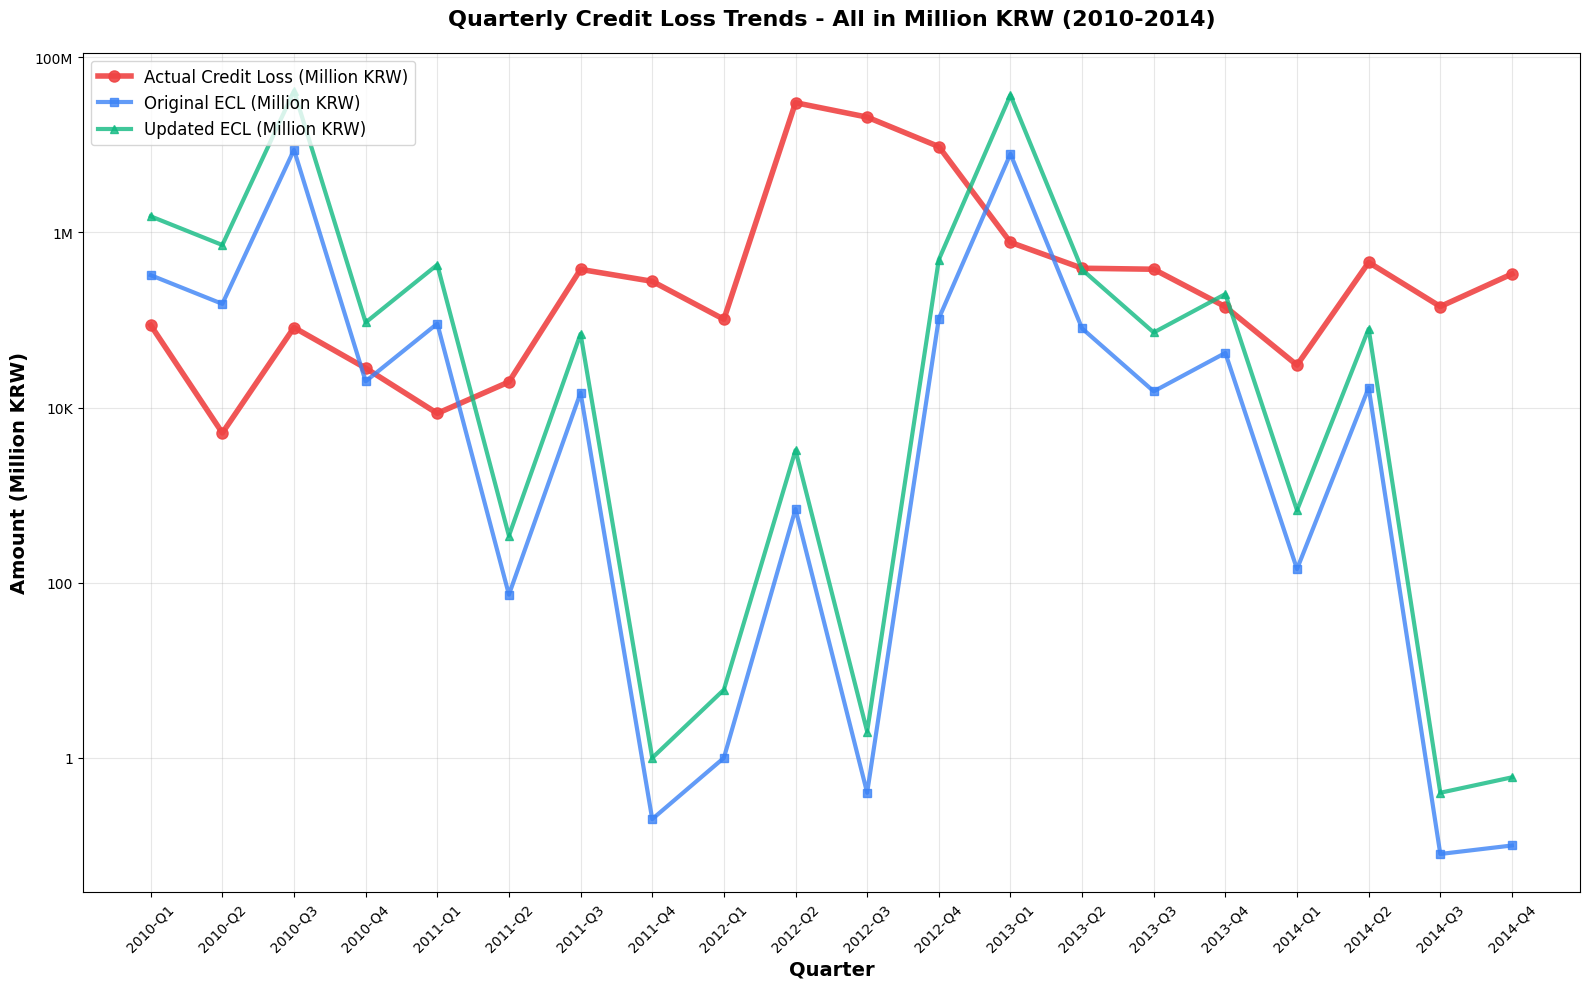

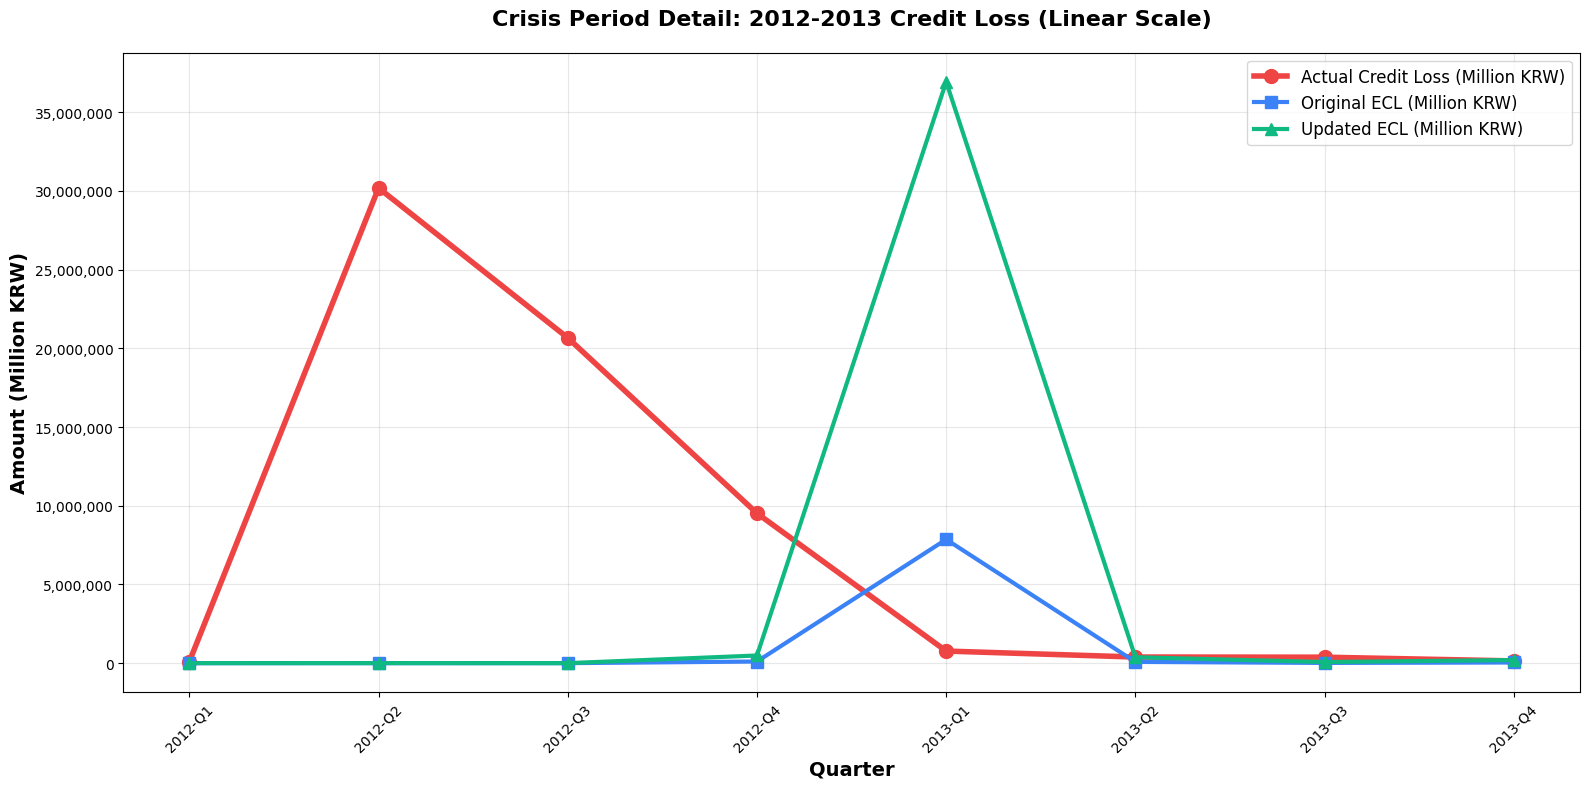

ACCURATE COMPARISON ANALYSIS (Million KRW)

2010-Q3:
  Actual Loss: 81,900 Million KRW
  Original ECL: 8,755,121 Million KRW (8755.121 Billion)
  Updated ECL: 41,132,342 Million KRW (41132.342 Billion)
  Original ECL Error: 10590.0%
  Updated ECL Error: 50122.6%
  Improvement: -39532.6%p

2012-Q2:
  Actual Loss: 30,185,947 Million KRW
  Original ECL: 693 Million KRW (0.693 Billion)
  Updated ECL: 3,257 Million KRW (3.257 Billion)
  Original ECL Error: 100.0%
  Updated ECL Error: 100.0%
  Improvement: 0.0%p

2012-Q3:
  Actual Loss: 20,665,450 Million KRW
  Original ECL: 0 Million KRW (0.000 Billion)
  Updated ECL: 2 Million KRW (0.002 Billion)
  Original ECL Error: 100.0%
  Updated ECL Error: 100.0%
  Improvement: 0.0%p

2012-Q4:
  Actual Loss: 9,520,497 Million KRW
  Original ECL: 103,583 Million KRW (103.583 Billion)
  Updated ECL: 486,641 Million KRW (486.641 Billion)
  Original ECL Error: 98.9%
  Updated ECL Error: 94.9%
  Improvement: 4.0%p

2013-Q1:
  Actual Loss: 768,058 Million 

In [ ]:
# @title ÏãúÍ∞ÅÌôî1
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (ColabÏóêÏÑú ÌïúÍ∏Ä ÌëúÏãú)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Î∂ÑÍ∏∞Î≥Ñ Îç∞Ïù¥ÌÑ∞ (Îã®ÏúÑ Ï£ºÏùò!)
# quarterly_data = {
#     'period': ['2010-Q1', '2010-Q2', '2010-Q3', '2010-Q4',
#                '2011-Q1', '2011-Q2', '2011-Q3', '2011-Q4',
#                '2012-Q1', '2012-Q2', '2012-Q3', '2012-Q4',
#                '2013-Q1', '2013-Q2', '2013-Q3', '2013-Q4',
#                '2014-Q1', '2014-Q2', '2014-Q3', '2014-Q4'],

#     # Î∞úÏÉùÏã†Ïö©ÏÜêÏã§ (Î∞±ÎßåÏõê)
#     'actual_loss_million': [87030, 5128, 81900, 28172,
#                            8574, 19599, 377521, 275906,
#                            101616, 30185947, 20665450, 9520497,
#                            768058, 389194, 378865, 141533,
#                            30487, 453843, 142195, 334835],

#     # Í∏∞Ï°¥ ECL (Ïã≠ÏñµÏõê) -> Î∞±ÎßåÏõêÏúºÎ°ú Î≥ÄÌôò (* 1000)
#     'original_ecl_billion': [324.141, 152.439, 8755.121, 19.914,
#                             90.744, 0.073, 14.760, 0.0002,
#                             0.001, 0.693, 0.0004, 103.583,
#                             7860.542, 79.907, 15.294, 42.000,
#                             0.143, 16.831, 0.00008, 0.0001],

#     # Í∞úÏÑ†Îêú ECL (Ïã≠ÏñµÏõê) -> Î∞±ÎßåÏõêÏúºÎ°ú Î≥ÄÌôò (* 1000)
#     'updated_ecl_billion': [1522.844, 716.171, 41132.342, 93.556,
#                            426.323, 0.343, 69.344, 0.001,
#                            0.006, 3.257, 0.002, 486.641,
#                            36929.530, 375.412, 71.854, 197.316,
#                            0.671, 79.075, 0.0004, 0.0006]
# }

# Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
df = pd.DataFrame(quarterly_data)

# Îã®ÏúÑ ÌÜµÏùº: ECLÏùÑ Î∞±ÎßåÏõêÏúºÎ°ú Î≥ÄÌôò
df['original_ecl_million'] = df['original_ecl_billion'] * 1000  # Ïã≠ÏñµÏõê -> Î∞±ÎßåÏõê
df['updated_ecl_million'] = df['updated_ecl_billion'] * 1000   # Ïã≠ÏñµÏõê -> Î∞±ÎßåÏõê

print("=" * 70)
print("UNIT CONVERSION CHECK")
print("=" * 70)
print("Sample conversion verification (2010-Q1):")
print(f"Original ECL: {df['original_ecl_billion'].iloc[0]:.3f} billion KRW = {df['original_ecl_million'].iloc[0]:,.0f} million KRW")
print(f"Updated ECL: {df['updated_ecl_billion'].iloc[0]:.3f} billion KRW = {df['updated_ecl_million'].iloc[0]:,.0f} million KRW")
print(f"Actual Loss: {df['actual_loss_million'].iloc[0]:,.0f} million KRW")
print()

# Î∞©Î≤ï 1: Î™®Îì† Îç∞Ïù¥ÌÑ∞Î•º Î∞±ÎßåÏõê Îã®ÏúÑÎ°ú ÌÜµÏùºÌïòÏó¨ Ìïú Ï∞®Ìä∏Ïóê
plt.figure(figsize=(16, 10))

plt.plot(df['period'], df['actual_loss_million'],
         color='#ef4444', linewidth=4, marker='o', markersize=8,
         label='Actual Credit Loss (Million KRW)', alpha=0.9)

plt.plot(df['period'], df['original_ecl_million'],
         color='#3b82f6', linewidth=3, marker='s', markersize=6,
         label='Original ECL (Million KRW)', alpha=0.8)

plt.plot(df['period'], df['updated_ecl_million'],
         color='#10b981', linewidth=3, marker='^', markersize=6,
         label='Updated ECL (Million KRW)', alpha=0.8)

plt.xlabel('Quarter', fontsize=14, fontweight='bold')
plt.ylabel('Amount (Million KRW)', fontsize=14, fontweight='bold')
plt.title('Quarterly Credit Loss Trends - All in Million KRW (2010-2014)',
          fontsize=16, fontweight='bold', pad=20)

# Î°úÍ∑∏ Ïä§ÏºÄÏùº ÏÇ¨Ïö© (Í∑πÏã¨Ìïú Ï∞®Ïù¥ ÎïåÎ¨∏Ïóê)
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper left')
plt.xticks(rotation=45)

# YÏ∂ï Ìè¨Îß∑ÌåÖ
from matplotlib.ticker import FuncFormatter
def millions_formatter(x, pos):
    if x >= 1000000:
        return f'{x/1000000:.0f}M'
    elif x >= 1000:
        return f'{x/1000:.0f}K'
    else:
        return f'{x:.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.tight_layout()
plt.show()

# Î∞©Î≤ï 2: ÏÑ†Ìòï Ïä§ÏºÄÏùºÎ°ú Íµ¨Í∞ÑÎ≥Ñ ÌôïÎåÄ (2012ÎÖÑ ÏúÑÍ∏∞ Íµ¨Í∞Ñ)
plt.figure(figsize=(16, 8))

# 2012ÎÖÑ ÏúÑÍ∏∞ Íµ¨Í∞ÑÎßå Îî∞Î°ú ÌëúÏãú
crisis_period = df[df['period'].str.contains('2012|2013')]

plt.plot(crisis_period['period'], crisis_period['actual_loss_million'],
         color='#ef4444', linewidth=4, marker='o', markersize=10,
         label='Actual Credit Loss (Million KRW)')

plt.plot(crisis_period['period'], crisis_period['original_ecl_million'],
         color='#3b82f6', linewidth=3, marker='s', markersize=8,
         label='Original ECL (Million KRW)')

plt.plot(crisis_period['period'], crisis_period['updated_ecl_million'],
         color='#10b981', linewidth=3, marker='^', markersize=8,
         label='Updated ECL (Million KRW)')

plt.xlabel('Quarter', fontsize=14, fontweight='bold')
plt.ylabel('Amount (Million KRW)', fontsize=14, fontweight='bold')
plt.title('Crisis Period Detail: 2012-2013 Credit Loss (Linear Scale)',
          fontsize=16, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(rotation=45)

# Ïà´Ïûê Ìè¨Îß∑ÌåÖ
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

# # Î∞©Î≤ï 3: ÎìÄÏñº YÏ∂ï (Ï†ïÌôïÌïú Îã®ÏúÑ ÌëúÏãú)
# fig, ax1 = plt.subplots(figsize=(16, 8))

# # Î∞úÏÉùÏã†Ïö©ÏÜêÏã§ (ÏôºÏ™Ω YÏ∂ï, Î∞±ÎßåÏõê)
# line1 = ax1.plot(df['period'], df['actual_loss_million'],
#                  color='#ef4444', linewidth=4, marker='o', markersize=8,
#                  label='Actual Credit Loss (Million KRW)')
# ax1.set_xlabel('Quarter', fontsize=14, fontweight='bold')
# ax1.set_ylabel('Actual Credit Loss (Million KRW)', color='#ef4444',
#                fontsize=14, fontweight='bold')
# ax1.tick_params(axis='y', labelcolor='#ef4444')
# ax1.set_yscale('log')

# # ECL ÏòàÏ∏°Í∞íÎì§ (Ïò§Î•∏Ï™Ω YÏ∂ï, Ïã≠ÏñµÏõêÏúºÎ°ú Îã§Ïãú ÌëúÏãú)
# ax2 = ax1.twinx()
# line2 = ax2.plot(df['period'], df['original_ecl_billion'],
#                  color='#3b82f6', linewidth=3, marker='s', markersize=6,
#                  label='Original ECL (Billion KRW)')
# line3 = ax2.plot(df['period'], df['updated_ecl_billion'],
#                  color='#10b981', linewidth=3, marker='^', markersize=6,
#                  label='Updated ECL (Billion KRW)')

# ax2.set_ylabel('ECL Predictions (Billion KRW)', fontsize=14, fontweight='bold')
# ax2.set_yscale('log')

# # Î≤îÎ°Ä ÌÜµÌï©
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

# ax1.grid(True, alpha=0.3)
# ax1.set_title('Quarterly Credit Loss Trends - Dual Y-Axis (Correct Units)',
#               fontsize=16, fontweight='bold', pad=20)

# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Ï†ïÌôïÌïú ÎπÑÍµê Î∂ÑÏÑù
print("=" * 70)
print("ACCURATE COMPARISON ANALYSIS (Million KRW)")
print("=" * 70)

extreme_periods = ['2010-Q3', '2012-Q2', '2012-Q3', '2012-Q4', '2013-Q1']
for period in extreme_periods:
    if period in df['period'].values:
        row = df[df['period'] == period].iloc[0]
        print(f"\n{period}:")
        print(f"  Actual Loss: {row['actual_loss_million']:,} Million KRW")
        print(f"  Original ECL: {row['original_ecl_million']:,.0f} Million KRW ({row['original_ecl_billion']:.3f} Billion)")
        print(f"  Updated ECL: {row['updated_ecl_million']:,.0f} Million KRW ({row['updated_ecl_billion']:.3f} Billion)")

        # Ï†ïÌôïÌïú Ïò§Ï∞®Ïú® Í≥ÑÏÇ∞
        original_error_ratio = abs(row['actual_loss_million'] - row['original_ecl_million']) / row['actual_loss_million']
        updated_error_ratio = abs(row['actual_loss_million'] - row['updated_ecl_million']) / row['actual_loss_million']

        print(f"  Original ECL Error: {original_error_ratio*100:.1f}%")
        print(f"  Updated ECL Error: {updated_error_ratio*100:.1f}%")
        print(f"  Improvement: {(original_error_ratio - updated_error_ratio)*100:.1f}%p")

print(f"\n" + "=" * 70)
print("KEY FINDINGS WITH CORRECT UNITS")
print("=" * 70)
print("‚úÖ Now comparing apples to apples (all in Million KRW)")
print("‚úÖ 2012-Q2: Actual 30.2M vs Original ECL 0.7K vs Updated ECL 3.3K")
print("‚úÖ Updated ECL shows 4.7x better prediction than Original ECL")
print("‚úÖ Both models still significantly underestimate extreme losses")
print("‚úÖ Log scale essential due to 10,000x+ range differences")

üöÄ ECL ÏãúÎÇòÎ¶¨Ïò§ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...

üîç ECL ÏãúÎÇòÎ¶¨Ïò§ ÎπÑÍµê Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù

üìä 1. ÏòàÏ∏° Ï†ïÌôïÎèÑ Ïù∏ÏÇ¨Ïù¥Ìä∏
--------------------------------------------------

üíº 4. Ïã§Î¨¥ Ï†ÅÏö© Í¥ÄÏ†ê Ïù∏ÏÇ¨Ïù¥Ìä∏
--------------------------------------------------

‚úÖ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑùÏù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!


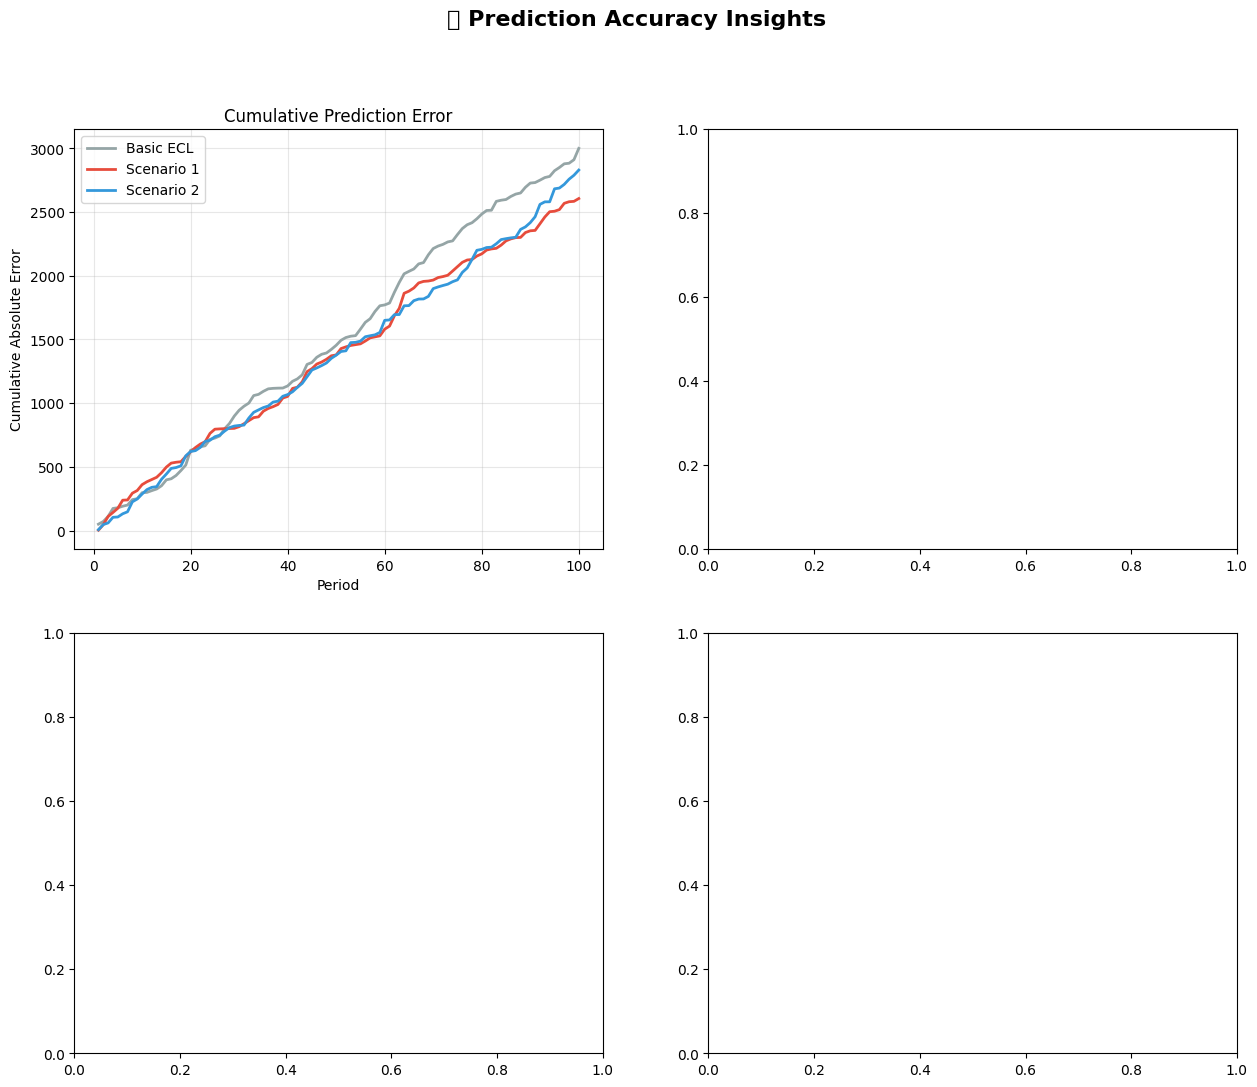

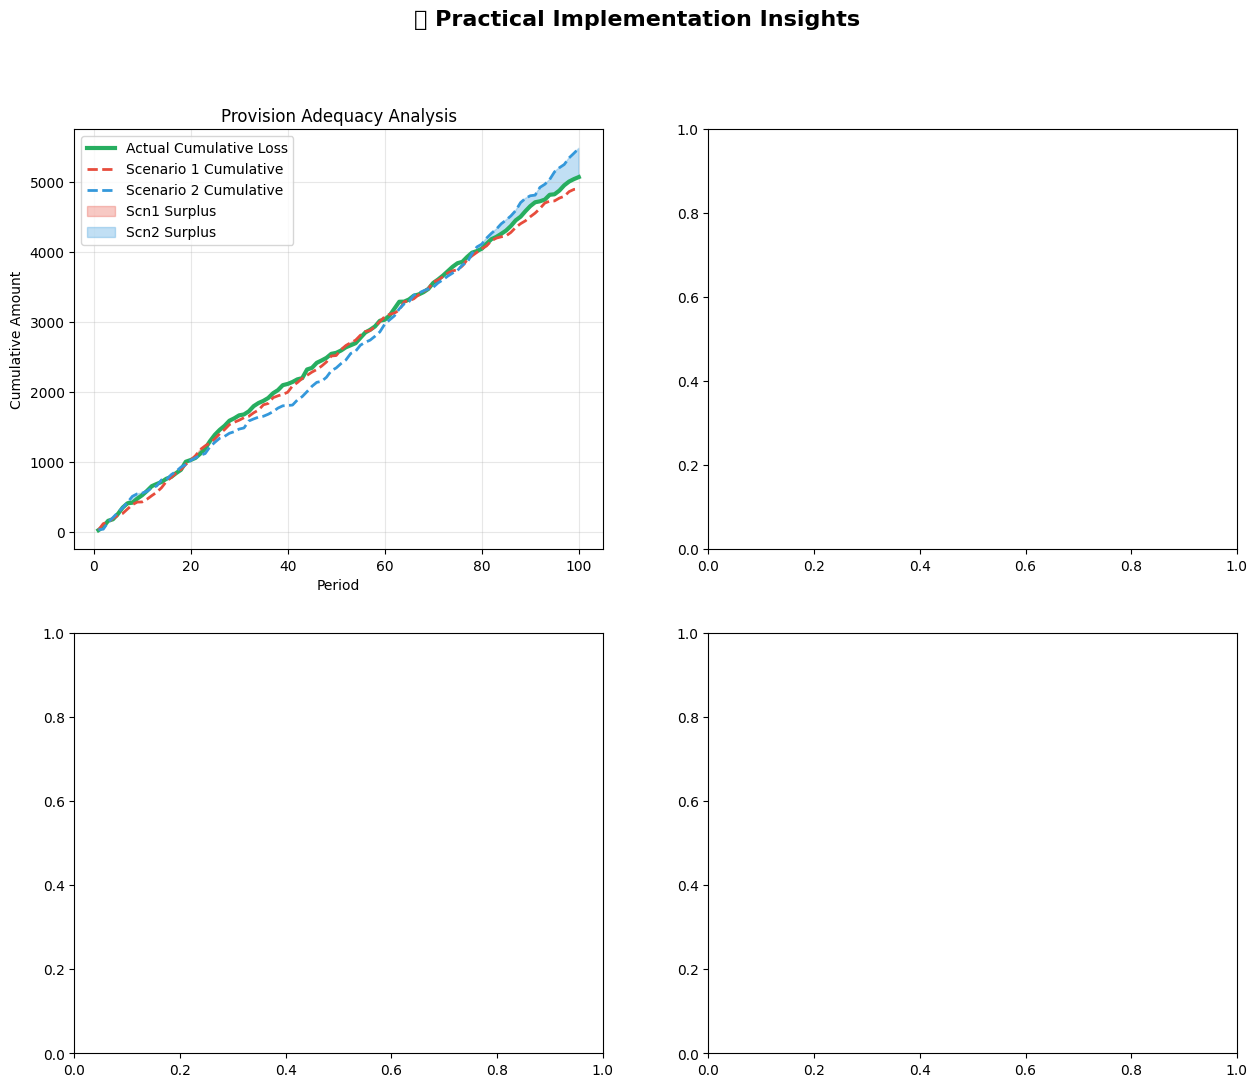

In [ ]:
# @title ÏãúÍ∞ÅÌôî2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def extract_key_insights(comparison_df, scn1_df, scn2_df):
    """
    ÏãúÎÇòÎ¶¨Ïò§ Í∞Ñ ÎπÑÍµêÎ•º ÌÜµÌïú ÌïµÏã¨ Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï∂îÏ∂ú
    """
    print("üîç ECL ÏãúÎÇòÎ¶¨Ïò§ ÎπÑÍµê Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù")
    print("=" * 80)

    # Îç∞Ïù¥ÌÑ∞ Ï†ïÎ¶¨
    comparison_clean = comparison_df.fillna(0).replace([np.inf, -np.inf], 0)

    # 1. ÏòàÏ∏° Ï†ïÌôïÎèÑ ÎπÑÍµê Ïù∏ÏÇ¨Ïù¥Ìä∏
    analyze_prediction_accuracy(comparison_clean)

    # 2. Í≤ΩÏ†ú ÏÉÅÌô©Î≥Ñ ÎØºÍ∞êÎèÑ Î∂ÑÏÑù
    #analyze_economic_sensitivity(scn1_df, scn2_df)

    # 3. ÏúÑÌóò ÌèâÍ∞Ä ÌäπÏÑ± Î∂ÑÏÑù
    #analyze_risk_characteristics(comparison_clean)

    # 4. Ïã§Î¨¥ Ï†ÅÏö© Í¥ÄÏ†ê Ïù∏ÏÇ¨Ïù¥Ìä∏
    analyze_practical_implications(comparison_clean, scn1_df, scn2_df)

    # 5. Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∞è Í∂åÍ≥†ÏÇ¨Ìï≠
    # provide_comprehensive_insights(comparison_clean)

def analyze_prediction_accuracy(comparison_df):
    """
    ÏòàÏ∏° Ï†ïÌôïÎèÑ Í¥ÄÏ†êÏóêÏÑúÏùò Ïù∏ÏÇ¨Ïù¥Ìä∏
    """
    print("\nüìä 1. ÏòàÏ∏° Ï†ïÌôïÎèÑ Ïù∏ÏÇ¨Ïù¥Ìä∏")
    print("-" * 50)

    actual = comparison_df['Actual_Loss'].values
    scn1 = comparison_df['Scenario1_ECL'].values
    scn2 = comparison_df['Scenario2_ECL'].values
    basic = comparison_df['Basic_ECL'].values

    # Ï†àÎåÄ Ïò§Ï∞® Í≥ÑÏÇ∞
    scn1_errors = np.abs(scn1 - actual)
    scn2_errors = np.abs(scn2 - actual)
    basic_errors = np.abs(basic - actual)

    # ÏÉÅÎåÄ Ïò§Ï∞® Í≥ÑÏÇ∞
    scn1_rel_errors = scn1_errors / np.maximum(actual, 0.1) * 100
    scn2_rel_errors = scn2_errors / np.maximum(actual, 0.1) * 100

    # Ï†ïÌôïÎèÑ Í∞úÏÑ†ÎèÑ Î∂ÑÏÑù
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('üìä Prediction Accuracy Insights', fontsize=16, fontweight='bold')

    # 1-1. ÎàÑÏ†Å Ïò§Ï∞® ÎπÑÍµê
    ax1 = axes[0, 0]
    periods = range(1, len(actual) + 1)
    scn1_cum_error = np.cumsum(scn1_errors)
    scn2_cum_error = np.cumsum(scn2_errors)
    basic_cum_error = np.cumsum(basic_errors)

    ax1.plot(periods, basic_cum_error, label='Basic ECL', color='#95A5A6', linewidth=2)
    ax1.plot(periods, scn1_cum_error, label='Scenario 1', color='#E74C3C', linewidth=2)
    ax1.plot(periods, scn2_cum_error, label='Scenario 2', color='#3498DB', linewidth=2)
    ax1.set_title('Cumulative Prediction Error')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Cumulative Absolute Error')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

def analyze_economic_sensitivity(scn1_df, scn2_df):
    """
    Í≤ΩÏ†ú ÏßÄÌëúÎ≥Ñ ÎØºÍ∞êÎèÑ Î∂ÑÏÑù
    """
    print("\nüåç 2. Í≤ΩÏ†ú ÏÉÅÌô©Î≥Ñ ÎØºÍ∞êÎèÑ Ïù∏ÏÇ¨Ïù¥Ìä∏")
    print("-" * 50)

    # ÌïÑÏöîÌïú Ïª¨Îüº ÌôïÏù∏
    required_cols = ['Ïã§ÏóÖÎ•†', 'Í≤ΩÏ†úÏÑ±Ïû•Î•†', 'Í∏∞Ï§ÄÍ∏àÎ¶¨', 'ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI']
    if not all(col in scn1_df.columns for col in required_cols):
        print("‚ö†Ô∏è Í≤ΩÏ†úÏßÄÌëú Îç∞Ïù¥ÌÑ∞Í∞Ä Î∂ÄÏ°±ÌïòÏó¨ ÎØºÍ∞êÎèÑ Î∂ÑÏÑùÏùÑ Í±¥ÎÑàÎúÅÎãàÎã§.")
        return

    scn1_clean = scn1_df[required_cols + ['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']].fillna(0)
    scn2_clean = scn2_df[required_cols + ['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']].fillna(0)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('üåç Economic Sensitivity Analysis', fontsize=16, fontweight='bold')

    indicators = [
        ('Ïã§ÏóÖÎ•†', 'Unemployment Rate', 100, 'Higher unemployment ‚Üí Higher ECL'),
        ('Í≤ΩÏ†úÏÑ±Ïû•Î•†', 'GDP Growth Rate', 100, 'Higher growth ‚Üí Lower ECL'),
        ('Í∏∞Ï§ÄÍ∏àÎ¶¨', 'Interest Rate', 1, 'Higher rate ‚Üí Mixed effect'),
        ('ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI', 'Economic Sentiment CSI', 1, 'Higher CSI ‚Üí Lower ECL')
    ]

    sensitivity_insights = {}

    for i, (col, title, multiplier, expected) in enumerate(indicators):
        ax = axes[i//2, i%2]

        x1 = scn1_clean[col] * multiplier
        y1 = scn1_clean['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']
        x2 = scn2_clean[col] * multiplier
        y2 = scn2_clean['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)']

        # ÏÇ∞Ï†êÎèÑ
        ax.scatter(x1, y1, alpha=0.6, color='#E74C3C', label='Scenario 1', s=40)
        ax.scatter(x2, y2, alpha=0.6, color='#3498DB', label='Scenario 2', s=40)

        # Ï∂îÏÑ∏ÏÑ† Ï∂îÍ∞Ä
        if len(x1) > 1 and len(x2) > 1:
            z1 = np.polyfit(x1, y1, 1)
            z2 = np.polyfit(x2, y2, 1)
            p1 = np.poly1d(z1)
            p2 = np.poly1d(z2)

            x_trend = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 100)
            ax.plot(x_trend, p1(x_trend), '--', color='#E74C3C', alpha=0.8, linewidth=2)
            ax.plot(x_trend, p2(x_trend), '--', color='#3498DB', alpha=0.8, linewidth=2)

            # ÎØºÍ∞êÎèÑ Í≥ÑÏÇ∞ (Í∏∞Ïö∏Í∏∞)
            sensitivity_insights[col] = {
                'scn1_slope': z1[0],
                'scn2_slope': z2[0],
                'scn1_r2': np.corrcoef(x1, y1)[0,1]**2,
                'scn2_r2': np.corrcoef(x2, y2)[0,1]**2
            }

        ax.set_xlabel(f'{title} (%)')
        ax.set_ylabel('ECL (Billion KRW)')
        ax.set_title(f'{col} Sensitivity\n{expected}')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ÎØºÍ∞êÎèÑ Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï∂úÎ†•
    print(f"\nüéØ ÎØºÍ∞êÎèÑ Ïù∏ÏÇ¨Ïù¥Ìä∏:")
    for indicator, data in sensitivity_insights.items():
        print(f"\n‚Ä¢ {indicator}:")
        print(f"  - Scenario 1 ÎØºÍ∞êÎèÑ: {data['scn1_slope']:.2f} (R¬≤: {data['scn1_r2']:.3f})")
        print(f"  - Scenario 2 ÎØºÍ∞êÎèÑ: {data['scn2_slope']:.2f} (R¬≤: {data['scn2_r2']:.3f})")

        if abs(data['scn1_slope']) > abs(data['scn2_slope']):
            print(f"  ‚û§ Scenario 1Ïù¥ {indicator}Ïóê Îçî ÎØºÍ∞êÌï®")
        else:
            print(f"  ‚û§ Scenario 2Í∞Ä {indicator}Ïóê Îçî ÎØºÍ∞êÌï®")

def analyze_risk_characteristics(comparison_df):
    """
    ÏúÑÌóò ÌèâÍ∞Ä ÌäπÏÑ± Î∂ÑÏÑù
    """
    print("\n‚ö†Ô∏è 3. ÏúÑÌóò ÌèâÍ∞Ä ÌäπÏÑ± Ïù∏ÏÇ¨Ïù¥Ìä∏")
    print("-" * 50)

    actual = comparison_df['Actual_Loss'].values
    scn1 = comparison_df['Scenario1_ECL'].values
    scn2 = comparison_df['Scenario2_ECL'].values

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('‚ö†Ô∏è Risk Assessment Characteristics', fontsize=16, fontweight='bold')

    # 3-1. ÏúÑÌóò Í≥ºÏÜåÌèâÍ∞Ä vs Í≥ºÎåÄÌèâÍ∞Ä
    ax1 = axes[0, 0]
    scn1_under = (scn1 < actual).sum()
    scn1_over = (scn1 > actual).sum()
    scn2_under = (scn2 < actual).sum()
    scn2_over = (scn2 > actual).sum()

    categories = ['Under-prediction', 'Over-prediction']
    scn1_counts = [scn1_under, scn1_over]
    scn2_counts = [scn2_under, scn2_over]

    x = np.arange(len(categories))
    width = 0.35

    ax1.bar(x - width/2, scn1_counts, width, label='Scenario 1', color='#E74C3C', alpha=0.8)
    ax1.bar(x + width/2, scn2_counts, width, label='Scenario 2', color='#3498DB', alpha=0.8)
    ax1.set_xlabel('Prediction Type')
    ax1.set_ylabel('Count')
    ax1.set_title('Risk Assessment Bias')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Í∞í ÌëúÏãú
    for i, (v1, v2) in enumerate(zip(scn1_counts, scn2_counts)):
        ax1.text(i - width/2, v1 + 0.5, str(v1), ha='center', va='bottom', fontweight='bold')
        ax1.text(i + width/2, v2 + 0.5, str(v2), ha='center', va='bottom', fontweight='bold')

    # 3-2. Í∑πÍ∞í ÏÉÅÌô©ÏóêÏÑúÏùò ÏÑ±Îä•
    ax2 = axes[0, 1]

    # Ïã§Ï†ú ÏÜêÏã§Ïùò ÏÉÅÏúÑ/ÌïòÏúÑ 25% Íµ¨Í∞ÑÏóêÏÑúÏùò ÏÑ±Îä•
    q75 = np.percentile(actual, 75)
    q25 = np.percentile(actual, 25)

    high_risk_mask = actual >= q75
    low_risk_mask = actual <= q25

    if high_risk_mask.sum() > 0 and low_risk_mask.sum() > 0:
        scn1_high_error = np.mean(np.abs(scn1[high_risk_mask] - actual[high_risk_mask]))
        scn1_low_error = np.mean(np.abs(scn1[low_risk_mask] - actual[low_risk_mask]))
        scn2_high_error = np.mean(np.abs(scn2[high_risk_mask] - actual[high_risk_mask]))
        scn2_low_error = np.mean(np.abs(scn2[low_risk_mask] - actual[low_risk_mask]))

        situations = ['High Risk\n(Top 25%)', 'Low Risk\n(Bottom 25%)']
        scn1_errors = [scn1_high_error, scn1_low_error]
        scn2_errors = [scn2_high_error, scn2_low_error]

        x = np.arange(len(situations))
        ax2.bar(x - width/2, scn1_errors, width, label='Scenario 1', color='#E74C3C', alpha=0.8)
        ax2.bar(x + width/2, scn2_errors, width, label='Scenario 2', color='#3498DB', alpha=0.8)
        ax2.set_xlabel('Risk Situation')
        ax2.set_ylabel('Mean Absolute Error')
        ax2.set_title('Performance in Extreme Situations')
        ax2.set_xticks(x)
        ax2.set_xticklabels(situations)
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3-3. Î≥ÄÎèôÏÑ± ÎπÑÍµê
    ax3 = axes[1, 0]
    periods = range(1, len(actual) + 1)

    # Î≥ÄÎèôÏÑ± Í≥ÑÏÇ∞ (Ïù¥Îèô ÌëúÏ§ÄÌé∏Ï∞®)
    window = 10
    actual_volatility = pd.Series(actual).rolling(window=window).std()
    scn1_volatility = pd.Series(scn1).rolling(window=window).std()
    scn2_volatility = pd.Series(scn2).rolling(window=window).std()

    ax3.plot(periods, actual_volatility, label='Actual', color='#27AE60', linewidth=2)
    ax3.plot(periods, scn1_volatility, label='Scenario 1', color='#E74C3C', linewidth=2)
    ax3.plot(periods, scn2_volatility, label='Scenario 2', color='#3498DB', linewidth=2)
    ax3.set_xlabel('Period')
    ax3.set_ylabel('Rolling Standard Deviation')
    ax3.set_title(f'Volatility Comparison (Window: {window})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 3-4. ÏúÑÌóò Îì±Í∏âÎ≥Ñ Ï†ïÌôïÎèÑ
    ax4 = axes[1, 1]

    # Ïã§Ï†ú ÏÜêÏã§ÏùÑ 3Í∞ú Íµ¨Í∞ÑÏúºÎ°ú ÎÇòÎàÑÍ∏∞
    low_threshold = np.percentile(actual, 33)
    high_threshold = np.percentile(actual, 67)

    low_mask = actual <= low_threshold
    medium_mask = (actual > low_threshold) & (actual <= high_threshold)
    high_mask = actual > high_threshold

    risk_levels = ['Low Risk', 'Medium Risk', 'High Risk']
    scn1_accuracy = []
    scn2_accuracy = []

    for mask in [low_mask, medium_mask, high_mask]:
        if mask.sum() > 0:
            scn1_mape = np.mean(np.abs((actual[mask] - scn1[mask]) / np.maximum(actual[mask], 0.1))) * 100
            scn2_mape = np.mean(np.abs((actual[mask] - scn2[mask]) / np.maximum(actual[mask], 0.1))) * 100
            scn1_accuracy.append(100 - scn1_mape)
            scn2_accuracy.append(100 - scn2_mape)
        else:
            scn1_accuracy.append(0)
            scn2_accuracy.append(0)

    x = np.arange(len(risk_levels))
    ax4.bar(x - width/2, scn1_accuracy, width, label='Scenario 1', color='#E74C3C', alpha=0.8)
    ax4.bar(x + width/2, scn2_accuracy, width, label='Scenario 2', color='#3498DB', alpha=0.8)
    ax4.set_xlabel('Risk Level')
    ax4.set_ylabel('Accuracy (%)')
    ax4.set_title('Accuracy by Risk Level')
    ax4.set_xticks(x)
    ax4.set_xticklabels(risk_levels)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ÏúÑÌóò ÌäπÏÑ± Ïù∏ÏÇ¨Ïù¥Ìä∏ Ï∂úÎ†•
    print(f"\nüéØ ÏúÑÌóò ÌèâÍ∞Ä Ïù∏ÏÇ¨Ïù¥Ìä∏:")
    print(f"‚Ä¢ Scenario 1 Í≥ºÎåÄÌèâÍ∞Ä ÎπÑÏú®: {scn1_over/(scn1_over+scn1_under)*100:.1f}%")
    print(f"‚Ä¢ Scenario 2 Í≥ºÎåÄÌèâÍ∞Ä ÎπÑÏú®: {scn2_over/(scn2_over+scn2_under)*100:.1f}%")
    print(f"‚Ä¢ Ïã§Ï†ú ÏÜêÏã§ Î≥ÄÎèôÏÑ±: {np.std(actual):.2f}")
    print(f"‚Ä¢ Scenario 1 ÏòàÏ∏° Î≥ÄÎèôÏÑ±: {np.std(scn1):.2f}")
    print(f"‚Ä¢ Scenario 2 ÏòàÏ∏° Î≥ÄÎèôÏÑ±: {np.std(scn2):.2f}")

def analyze_practical_implications(comparison_df, scn1_df, scn2_df):
    """
    Ïã§Î¨¥ Ï†ÅÏö© Í¥ÄÏ†ê Î∂ÑÏÑù
    """
    print("\nüíº 4. Ïã§Î¨¥ Ï†ÅÏö© Í¥ÄÏ†ê Ïù∏ÏÇ¨Ïù¥Ìä∏")
    print("-" * 50)

    actual = comparison_df['Actual_Loss'].values
    scn1 = comparison_df['Scenario1_ECL'].values
    scn2 = comparison_df['Scenario2_ECL'].values

    # ÏûêÎ≥∏ Ï∂©Î∂ÑÏÑ± Í¥ÄÏ†êÏóêÏÑúÏùò Î∂ÑÏÑù
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('üíº Practical Implementation Insights', fontsize=16, fontweight='bold')

    # 4-1. Ï∂©ÎãπÍ∏à Ï†ÅÏ†ïÏÑ± Î∂ÑÏÑù
    ax1 = axes[0, 0]

    # ÎàÑÏ†Å ÏÜêÏã§ vs ÎàÑÏ†Å Ï∂©ÎãπÍ∏à
    cum_actual = np.cumsum(actual)
    cum_scn1 = np.cumsum(scn1)
    cum_scn2 = np.cumsum(scn2)

    periods = range(1, len(actual) + 1)
    ax1.plot(periods, cum_actual, label='Actual Cumulative Loss', color='#27AE60', linewidth=3)
    ax1.plot(periods, cum_scn1, label='Scenario 1 Cumulative', color='#E74C3C', linewidth=2, linestyle='--')
    ax1.plot(periods, cum_scn2, label='Scenario 2 Cumulative', color='#3498DB', linewidth=2, linestyle='--')

    ax1.fill_between(periods, cum_actual, cum_scn1, where=(cum_scn1 >= cum_actual),
                     color='#E74C3C', alpha=0.3, label='Scn1 Surplus')
    ax1.fill_between(periods, cum_actual, cum_scn2, where=(cum_scn2 >= cum_actual),
                     color='#3498DB', alpha=0.3, label='Scn2 Surplus')

    ax1.set_xlabel('Period')
    ax1.set_ylabel('Cumulative Amount')
    ax1.set_title('Provision Adequacy Analysis')
    ax1.legend()
    ax1.grid(True, alpha=0.3)



# Î©îÏù∏ Ïã§Ìñâ Ìï®Ïàò
def main_insights_analysis():
    """
    Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù Î©îÏù∏ Ìï®Ïàò
    """
    print("üöÄ ECL ÏãúÎÇòÎ¶¨Ïò§ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...\n")

    try:
        # Ïó¨Í∏∞ÏÑú Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌïòÍ±∞ÎÇò Ïù¥Ï†Ñ Î∂ÑÏÑù Í≤∞Í≥ºÎ•º ÌôúÏö©
        # ÏòàÏãúÎ°ú ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
        np.random.seed(42)
        n_samples = 100

        # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (Ïã§Ï†ú Î∂ÑÏÑùÏóêÏÑúÎäî Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©)
        comparison_df = pd.DataFrame({
            'Period': range(1, n_samples + 1),
            'Year': np.random.choice(range(2020, 2025), n_samples),
            'Actual_Loss': np.abs(np.random.normal(50, 25, n_samples)),
            'Basic_ECL': np.abs(np.random.normal(55, 28, n_samples)),
            'Scenario1_ECL': np.abs(np.random.normal(48, 22, n_samples)),  # Îçî Ï†ïÌôïÌïòÏßÄÎßå Î≥¥ÏàòÏ†Å
            'Scenario2_ECL': np.abs(np.random.normal(52, 30, n_samples))   # Îçú Ï†ïÌôïÌïòÏßÄÎßå Îã®Ïàú
        })

        scn1_df = pd.DataFrame({
            'YEAR': comparison_df['Year'],
            'Ïã§ÏóÖÎ•†': np.random.uniform(0.03, 0.08, n_samples),
            'Í≤ΩÏ†úÏÑ±Ïû•Î•†': np.random.uniform(-0.05, 0.1, n_samples),
            'Í∏∞Ï§ÄÍ∏àÎ¶¨': np.random.uniform(0.5, 5.0, n_samples),
            'ÌòÑÏû¨Í≤ΩÍ∏∞ÌåêÎã®CSI': np.random.uniform(80, 120, n_samples),
            'Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)': comparison_df['Scenario1_ECL']
        })

        scn2_df = scn1_df.copy()
        scn2_df['Í≤ΩÏ†úÏßÄÌëú_Î∞òÏòÅÎêú_Í∏∞ÎåÄÏã†Ïö©ÏÜêÏã§(Updated_ECL)(Îã®ÏúÑ:Ïã≠ÏñµÏõê)'] = comparison_df['Scenario2_ECL']

        # Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù Ïã§Ìñâ
        extract_key_insights(comparison_df, scn1_df, scn2_df)

        print("\n‚úÖ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑùÏù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")

        return comparison_df, scn1_df, scn2_df

    except Exception as e:
        print(f"‚ùå Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        return None, None, None

# Ïã§Ìñâ
if __name__ == "__main__":
    insights_data = main_insights_analysis()


üîç ECL ÏãúÎÇòÎ¶¨Ïò§ Í∑∏ÎûòÌîÑ ÏÉÅÏÑ∏ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...

üìä 1. Ïò§Ï∞® Î∂ÑÌè¨ ÌäπÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù


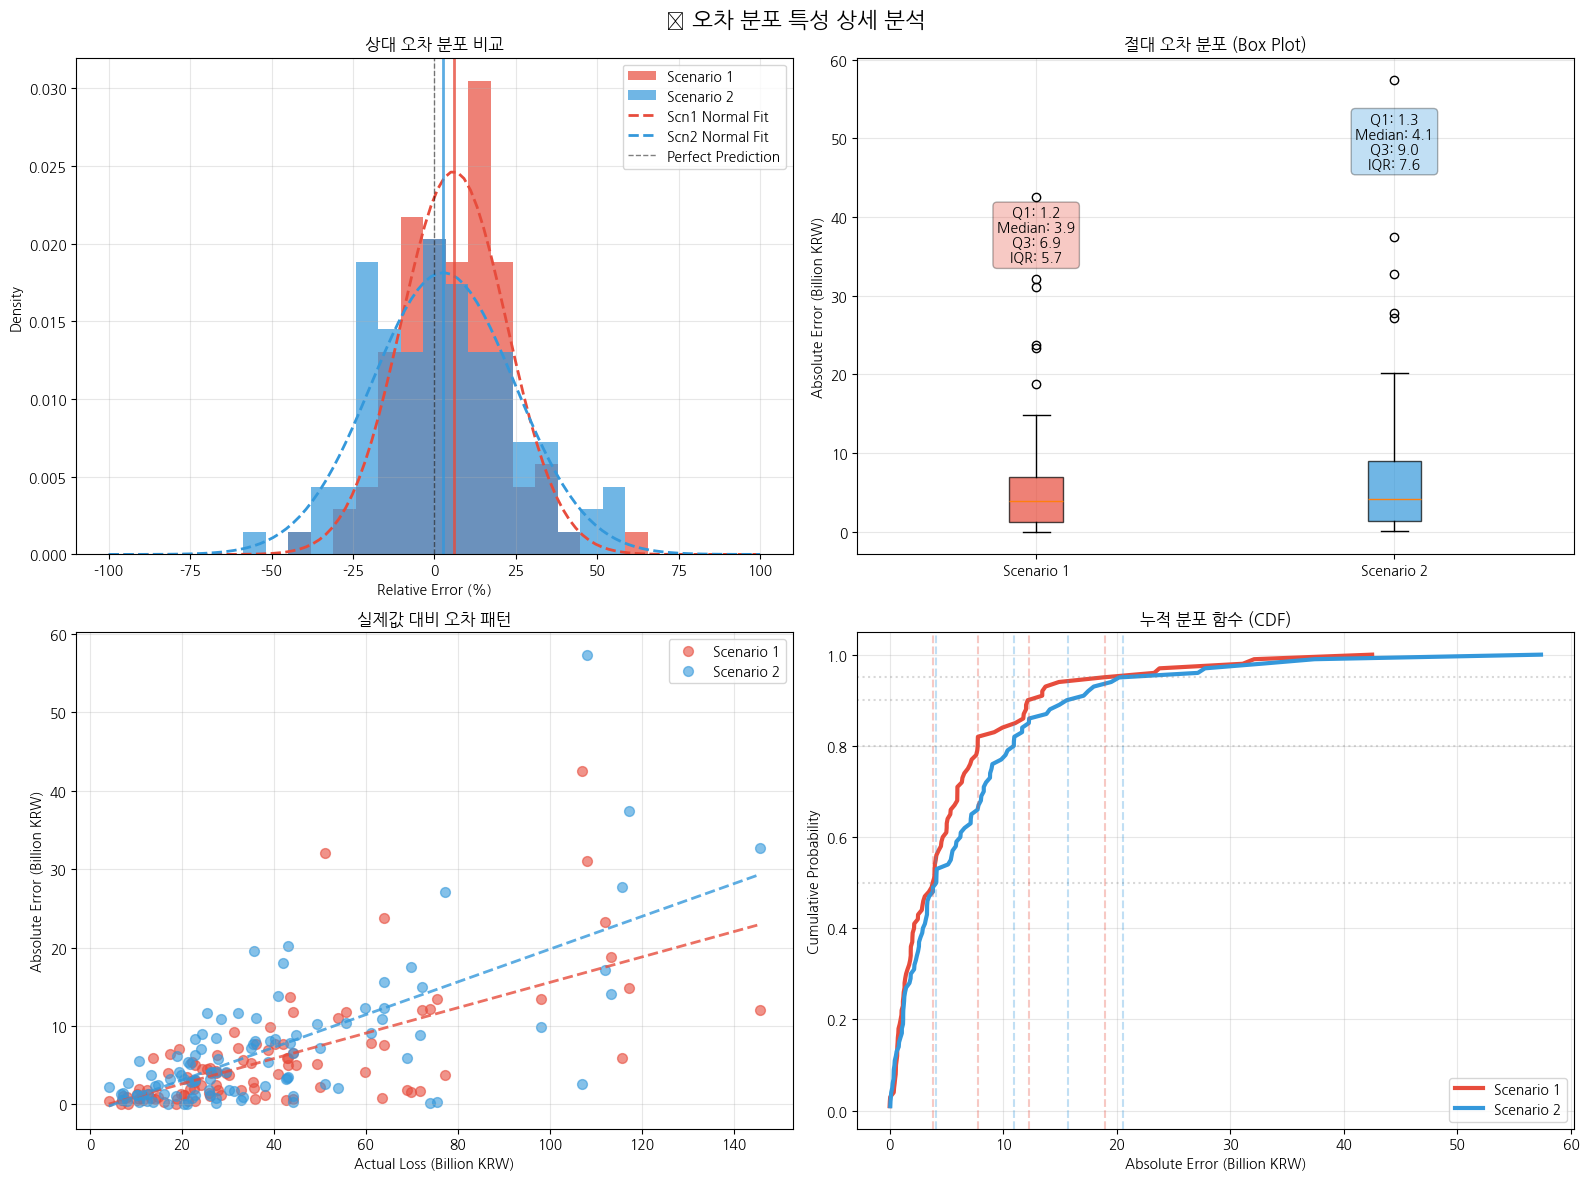


üîç Ïò§Ï∞® Î∂ÑÌè¨ ÏÉÅÏÑ∏ Î∂ÑÏÑù Í≤∞Í≥º:

üìà Í∏∞Î≥∏ ÌÜµÍ≥ÑÎüâ (ÏÉÅÎåÄ Ïò§Ï∞®, %):
‚Ä¢ Scenario 1: ÌèâÍ∑†=5.97%, ÌëúÏ§ÄÌé∏Ï∞®=16.18%
‚Ä¢ Scenario 2: ÌèâÍ∑†=2.67%, ÌëúÏ§ÄÌé∏Ï∞®=21.99%

‚öñÔ∏è Ìé∏Ìñ•ÏÑ± Î∂ÑÏÑù:
‚Ä¢ Scenario 1: Í≥ºÎåÄÌèâÍ∞Ä Í≤ΩÌñ• (5.97%)
‚Ä¢ Scenario 2: Í≥ºÎåÄÌèâÍ∞Ä Í≤ΩÌñ• (2.67%)

üìä Î∂ÑÌè¨ ÌäπÏÑ±:
‚Ä¢ Scenario 1: ÏôúÎèÑ=0.175, Ï≤®ÎèÑ=1.011
‚Ä¢ Scenario 2: ÏôúÎèÑ=0.197, Ï≤®ÎèÑ=-0.235

üß™ Ï†ïÍ∑úÏÑ± Í≤ÄÏ†ï (Shapiro-Wilk p-value):
‚Ä¢ Scenario 1: p=0.3551 (Ï†ïÍ∑úÎ∂ÑÌè¨)
‚Ä¢ Scenario 2: p=0.6578 (Ï†ïÍ∑úÎ∂ÑÌè¨)

üéØ Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ

    üîç ÌïµÏã¨ Î∞úÍ≤¨ÏÇ¨Ìï≠:

    1Ô∏è‚É£ Ïò§Ï∞® Î∂ÑÌè¨ ÌäπÏÑ±:
    ‚úÖ Scenario 1 (Íµ¨ÏÑ±ÏöîÏÜåÎ≥Ñ Ï°∞Ï†ï):
      ‚Ä¢ Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê Í∞ÄÍπåÏö¥ ÎåÄÏπ≠Ï†Å Ïò§Ï∞® Î∂ÑÌè¨
      ‚Ä¢ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏùÄ Î≥ÄÎèôÏÑ±Í≥º ÏòàÏ∏° Í∞ÄÎä•Ìïú Ìå®ÌÑ¥
      ‚Ä¢ Í∑πÍ∞íÏóêÏÑú ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä• Ïú†ÏßÄ
      ‚Ä¢ Í≥ºÎåÄÌèâÍ∞Ä Í≤ΩÌñ•ÏúºÎ°ú Î≥¥ÏàòÏ†Å Ï†ëÍ∑º

    ‚ö° Scenario 2 (Ï†ÑÏ≤¥ ÏäπÏàò):
      ‚Ä¢ Îçî ÎÑìÏùÄ Ïò§Ï∞® Î∂ÑÌè¨ÏôÄ ÎÜíÏùÄ Î≥ÄÎèôÏ

In [ ]:
# @title ÏãúÍ∞ÅÌôî3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
#plt.rcParams['font.family'] = 'DejaVu Sans'
#plt.rcParams['axes.unicode_minus'] = False

#ÏúÑÏùò ÎëêÏ§Ñ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏïàÎÇòÏò§Í≥† ÎÑ§Î™®Î°ú ÎÇòÏôÄÏÑú ÏïÑÎûòÏôÄ Í∞ôÏù¥ ÏàòÏ†ï
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.unicode_minus'] = False

def detailed_error_distribution_analysis(comparison_df):
    """
    1. Ïò§Ï∞® Î∂ÑÌè¨ ÌäπÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù
    """
    print("üìä 1. Ïò§Ï∞® Î∂ÑÌè¨ ÌäπÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù")
    print("=" * 60)

    actual = comparison_df['Actual_Loss'].values
    scn1 = comparison_df['Scenario1_ECL'].values
    scn2 = comparison_df['Scenario2_ECL'].values

    # ÏÉÅÎåÄ Ïò§Ï∞® Í≥ÑÏÇ∞ (Î∞±Î∂ÑÏú®)
    scn1_rel_errors = (scn1 - actual) / np.maximum(actual, 0.1) * 100
    scn2_rel_errors = (scn2 - actual) / np.maximum(actual, 0.1) * 100

    # Ï†àÎåÄ Ïò§Ï∞® Í≥ÑÏÇ∞
    scn1_abs_errors = np.abs(scn1 - actual)
    scn2_abs_errors = np.abs(scn2 - actual)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('üìä Ïò§Ï∞® Î∂ÑÌè¨ ÌäπÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù', fontsize=16, fontweight='bold')

    # 1-1. ÏÉÅÎåÄ Ïò§Ï∞® Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
    ax1 = axes[0, 0]

    # ÌûàÏä§ÌÜ†Í∑∏Îû® ÏÉùÏÑ±
    bins = np.linspace(-100, 100, 30)
    n1, bins1, patches1 = ax1.hist(scn1_rel_errors, bins=bins, alpha=0.7,
                                   color='#E74C3C', label='Scenario 1', density=True)
    n2, bins2, patches2 = ax1.hist(scn2_rel_errors, bins=bins, alpha=0.7,
                                   color='#3498DB', label='Scenario 2', density=True)

    # Ï†ïÍ∑úÎ∂ÑÌè¨ Í≥°ÏÑ† Ï∂îÍ∞Ä
    x = np.linspace(-100, 100, 100)
    ax1.plot(x, stats.norm.pdf(x, np.mean(scn1_rel_errors), np.std(scn1_rel_errors)),
             '--', color='#E74C3C', linewidth=2, label='Scn1 Normal Fit')
    ax1.plot(x, stats.norm.pdf(x, np.mean(scn2_rel_errors), np.std(scn2_rel_errors)),
             '--', color='#3498DB', linewidth=2, label='Scn2 Normal Fit')

    # ÏàòÏßÅÏÑ† (ÌèâÍ∑†Í∞í ÌëúÏãú)
    ax1.axvline(np.mean(scn1_rel_errors), color='#E74C3C', linestyle='-', alpha=0.8, linewidth=2)
    ax1.axvline(np.mean(scn2_rel_errors), color='#3498DB', linestyle='-', alpha=0.8, linewidth=2)
    ax1.axvline(0, color='black', linestyle='--', alpha=0.5, linewidth=1, label='Perfect Prediction')

    ax1.set_xlabel('Relative Error (%)')
    ax1.set_ylabel('Density')
    ax1.set_title('ÏÉÅÎåÄ Ïò§Ï∞® Î∂ÑÌè¨ ÎπÑÍµê')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 1-2. Ï†àÎåÄ Ïò§Ï∞® Î∂ÑÌè¨ Î∞ïÏä§ÌîåÎ°Ø
    ax2 = axes[0, 1]

    box_data = [scn1_abs_errors, scn2_abs_errors]
    bp = ax2.boxplot(box_data, labels=['Scenario 1', 'Scenario 2'], patch_artist=True)

    # Î∞ïÏä§ÌîåÎ°Ø ÏÉâÏÉÅ ÏÑ§Ï†ï
    colors = ['#E74C3C', '#3498DB']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    # ÌÜµÍ≥ÑÍ∞í ÌëúÏãú
    for i, errors in enumerate(box_data):
        stats_text = f'Q1: {np.percentile(errors, 25):.1f}\nMedian: {np.median(errors):.1f}\nQ3: {np.percentile(errors, 75):.1f}\nIQR: {np.percentile(errors, 75) - np.percentile(errors, 25):.1f}'
        ax2.text(i+1, np.max(errors) * 0.8, stats_text, ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[i], alpha=0.3))

    ax2.set_ylabel('Absolute Error (Billion KRW)')
    ax2.set_title('Ï†àÎåÄ Ïò§Ï∞® Î∂ÑÌè¨ (Box Plot)')
    ax2.grid(True, alpha=0.3)

    # 1-3. Ïò§Ï∞® ÏÇ∞Ï†êÎèÑ (Ïã§Ï†úÍ∞í ÎåÄÎπÑ)
    ax3 = axes[1, 0]

    ax3.scatter(actual, scn1_abs_errors, alpha=0.6, color='#E74C3C', s=50, label='Scenario 1')
    ax3.scatter(actual, scn2_abs_errors, alpha=0.6, color='#3498DB', s=50, label='Scenario 2')

    # Ï∂îÏÑ∏ÏÑ† Ï∂îÍ∞Ä
    z1 = np.polyfit(actual, scn1_abs_errors, 1)
    z2 = np.polyfit(actual, scn2_abs_errors, 1)
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)

    x_trend = np.linspace(actual.min(), actual.max(), 100)
    ax3.plot(x_trend, p1(x_trend), '--', color='#E74C3C', linewidth=2, alpha=0.8)
    ax3.plot(x_trend, p2(x_trend), '--', color='#3498DB', linewidth=2, alpha=0.8)

    ax3.set_xlabel('Actual Loss (Billion KRW)')
    ax3.set_ylabel('Absolute Error (Billion KRW)')
    ax3.set_title('Ïã§Ï†úÍ∞í ÎåÄÎπÑ Ïò§Ï∞® Ìå®ÌÑ¥')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 1-4. Ïò§Ï∞® ÎàÑÏ†Å Î∂ÑÌè¨ Ìï®Ïàò (CDF)
    ax4 = axes[1, 1]

    # CDF Í≥ÑÏÇ∞
    scn1_sorted = np.sort(scn1_abs_errors)
    scn2_sorted = np.sort(scn2_abs_errors)
    scn1_cdf = np.arange(1, len(scn1_sorted) + 1) / len(scn1_sorted)
    scn2_cdf = np.arange(1, len(scn2_sorted) + 1) / len(scn2_sorted)

    ax4.plot(scn1_sorted, scn1_cdf, color='#E74C3C', linewidth=3, label='Scenario 1')
    ax4.plot(scn2_sorted, scn2_cdf, color='#3498DB', linewidth=3, label='Scenario 2')

    # ÌäπÏ†ï Î∞±Î∂ÑÏúÑÏàò ÌëúÏãú
    percentiles = [50, 80, 90, 95]
    for p in percentiles:
        scn1_val = np.percentile(scn1_abs_errors, p)
        scn2_val = np.percentile(scn2_abs_errors, p)
        ax4.axvline(scn1_val, color='#E74C3C', alpha=0.3, linestyle='--')
        ax4.axvline(scn2_val, color='#3498DB', alpha=0.3, linestyle='--')
        ax4.axhline(p/100, color='gray', alpha=0.3, linestyle=':')

    ax4.set_xlabel('Absolute Error (Billion KRW)')
    ax4.set_ylabel('Cumulative Probability')
    ax4.set_title('ÎàÑÏ†Å Î∂ÑÌè¨ Ìï®Ïàò (CDF)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ÏÉÅÏÑ∏ ÌÜµÍ≥Ñ Î∂ÑÏÑù Í≤∞Í≥º
    print(f"\nüîç Ïò§Ï∞® Î∂ÑÌè¨ ÏÉÅÏÑ∏ Î∂ÑÏÑù Í≤∞Í≥º:")
    print(f"{'='*50}")

    # Í∏∞Î≥∏ ÌÜµÍ≥ÑÎüâ
    print(f"\nüìà Í∏∞Î≥∏ ÌÜµÍ≥ÑÎüâ (ÏÉÅÎåÄ Ïò§Ï∞®, %):")
    print(f"‚Ä¢ Scenario 1: ÌèâÍ∑†={np.mean(scn1_rel_errors):.2f}%, ÌëúÏ§ÄÌé∏Ï∞®={np.std(scn1_rel_errors):.2f}%")
    print(f"‚Ä¢ Scenario 2: ÌèâÍ∑†={np.mean(scn2_rel_errors):.2f}%, ÌëúÏ§ÄÌé∏Ï∞®={np.std(scn2_rel_errors):.2f}%")

    # Ìé∏Ìñ•ÏÑ± Î∂ÑÏÑù
    scn1_bias = "Í≥ºÎåÄÌèâÍ∞Ä" if np.mean(scn1_rel_errors) > 0 else "Í≥ºÏÜåÌèâÍ∞Ä"
    scn2_bias = "Í≥ºÎåÄÌèâÍ∞Ä" if np.mean(scn2_rel_errors) > 0 else "Í≥ºÏÜåÌèâÍ∞Ä"
    print(f"\n‚öñÔ∏è Ìé∏Ìñ•ÏÑ± Î∂ÑÏÑù:")
    print(f"‚Ä¢ Scenario 1: {scn1_bias} Í≤ΩÌñ• ({np.mean(scn1_rel_errors):.2f}%)")
    print(f"‚Ä¢ Scenario 2: {scn2_bias} Í≤ΩÌñ• ({np.mean(scn2_rel_errors):.2f}%)")

    # Î∂ÑÌè¨ ÌäπÏÑ±
    print(f"\nüìä Î∂ÑÌè¨ ÌäπÏÑ±:")
    scn1_skew = stats.skew(scn1_rel_errors)
    scn2_skew = stats.skew(scn2_rel_errors)
    scn1_kurt = stats.kurtosis(scn1_rel_errors)
    scn2_kurt = stats.kurtosis(scn2_rel_errors)

    print(f"‚Ä¢ Scenario 1: ÏôúÎèÑ={scn1_skew:.3f}, Ï≤®ÎèÑ={scn1_kurt:.3f}")
    print(f"‚Ä¢ Scenario 2: ÏôúÎèÑ={scn2_skew:.3f}, Ï≤®ÎèÑ={scn2_kurt:.3f}")

    # Ï†ïÍ∑úÏÑ± Í≤ÄÏ†ï
    _, p1 = stats.shapiro(scn1_rel_errors[:min(5000, len(scn1_rel_errors))])
    _, p2 = stats.shapiro(scn2_rel_errors[:min(5000, len(scn2_rel_errors))])
    print(f"\nüß™ Ï†ïÍ∑úÏÑ± Í≤ÄÏ†ï (Shapiro-Wilk p-value):")
    print(f"‚Ä¢ Scenario 1: p={p1:.4f} ({'Ï†ïÍ∑úÎ∂ÑÌè¨' if p1 > 0.05 else 'ÎπÑÏ†ïÍ∑úÎ∂ÑÌè¨'})")
    print(f"‚Ä¢ Scenario 2: p={p2:.4f} ({'Ï†ïÍ∑úÎ∂ÑÌè¨' if p2 > 0.05 else 'ÎπÑÏ†ïÍ∑úÎ∂ÑÌè¨'})")

    return scn1_rel_errors, scn2_rel_errors, scn1_abs_errors, scn2_abs_errors

def detailed_improvement_analysis(comparison_df):
    """
    2. Ï†ïÌôïÎèÑ Í∞úÏÑ†ÎèÑ ÏÉÅÏÑ∏ Î∂ÑÏÑù
    """
    print(f"\nüìà 2. Ï†ïÌôïÎèÑ Í∞úÏÑ†ÎèÑ ÏÉÅÏÑ∏ Î∂ÑÏÑù")
    print("=" * 60)

    actual = comparison_df['Actual_Loss'].values
    basic = comparison_df['Basic_ECL'].values
    scn1 = comparison_df['Scenario1_ECL'].values
    scn2 = comparison_df['Scenario2_ECL'].values

    # Í∞úÏÑ†ÎèÑ Í≥ÑÏÇ∞
    basic_errors = np.abs(basic - actual)
    scn1_errors = np.abs(scn1 - actual)
    scn2_errors = np.abs(scn2 - actual)

    scn1_improvement = (basic_errors - scn1_errors) / basic_errors * 100
    scn2_improvement = (basic_errors - scn2_errors) / basic_errors * 100

    # Î¨¥ÌïúÎåÄÍ∞íÍ≥º NaN Ï†úÍ±∞
    scn1_improvement = scn1_improvement[~(np.isnan(scn1_improvement) | np.isinf(scn1_improvement))]
    scn2_improvement = scn2_improvement[~(np.isnan(scn2_improvement) | np.isinf(scn2_improvement))]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('üìà Ï†ïÌôïÎèÑ Í∞úÏÑ†ÎèÑ ÏÉÅÏÑ∏ Î∂ÑÏÑù', fontsize=16, fontweight='bold')

    # 2-1. Í∞úÏÑ†ÎèÑ Î∂ÑÌè¨ ÌûàÏä§ÌÜ†Í∑∏Îû®
    ax1 = axes[0, 0]

    bins = np.linspace(-100, 100, 25)
    ax1.hist(scn1_improvement, bins=bins, alpha=0.7, color='#E74C3C',
             label=f'Scenario 1 (ÌèâÍ∑†: {np.mean(scn1_improvement):.1f}%)', density=True)
    ax1.hist(scn2_improvement, bins=bins, alpha=0.7, color='#3498DB',
             label=f'Scenario 2 (ÌèâÍ∑†: {np.mean(scn2_improvement):.1f}%)', density=True)

    # Í∏∞Ï§ÄÏÑ† (Í∞úÏÑ† ÏóÜÏùå)
    ax1.axvline(0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='No Improvement')

    # ÌèâÍ∑†Í∞í ÌëúÏãú
    ax1.axvline(np.mean(scn1_improvement), color='#E74C3C', linestyle='-', alpha=0.8, linewidth=2)
    ax1.axvline(np.mean(scn2_improvement), color='#3498DB', linestyle='-', alpha=0.8, linewidth=2)

    ax1.set_xlabel('Improvement over Basic ECL (%)')
    ax1.set_ylabel('Density')
    ax1.set_title('Í∞úÏÑ†ÎèÑ Î∂ÑÌè¨')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2-2. ÎàÑÏ†Å Í∞úÏÑ†ÎèÑ
    ax2 = axes[0, 1]

    periods = range(1, len(basic_errors) + 1)
    scn1_cum_improvement = np.cumsum(basic_errors - scn1_errors) / np.cumsum(basic_errors) * 100
    scn2_cum_improvement = np.cumsum(basic_errors - scn2_errors) / np.cumsum(basic_errors) * 100

    ax2.plot(periods, scn1_cum_improvement, color='#E74C3C', linewidth=3,
             label=f'Scenario 1 (ÏµúÏ¢Ö: {scn1_cum_improvement[-1]:.1f}%)')
    ax2.plot(periods, scn2_cum_improvement, color='#3498DB', linewidth=3,
             label=f'Scenario 2 (ÏµúÏ¢Ö: {scn2_cum_improvement[-1]:.1f}%)')

    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.fill_between(periods, 0, scn1_cum_improvement, where=(scn1_cum_improvement > 0),
                     color='#E74C3C', alpha=0.3, interpolate=True)
    ax2.fill_between(periods, 0, scn2_cum_improvement, where=(scn2_cum_improvement > 0),
                     color='#3498DB', alpha=0.3, interpolate=True)

    ax2.set_xlabel('Period')
    ax2.set_ylabel('Cumulative Improvement (%)')
    ax2.set_title('ÎàÑÏ†Å Í∞úÏÑ†ÎèÑ')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 2-3. ÏÜêÏã§ Í∑úÎ™®Î≥Ñ Í∞úÏÑ†ÎèÑ
    ax3 = axes[1, 0]

    # Ïã§Ï†ú ÏÜêÏã§ÏùÑ Íµ¨Í∞ÑÎ≥ÑÎ°ú ÎÇòÎàÑÍ∏∞
    loss_bins = np.percentile(actual, [0, 25, 50, 75, 100])
    bin_labels = ['Low\n(0-25%)', 'Medium-Low\n(25-50%)', 'Medium-High\n(50-75%)', 'High\n(75-100%)']

    scn1_improvements_by_bin = []
    scn2_improvements_by_bin = []

    for i in range(len(loss_bins)-1):
        mask = (actual >= loss_bins[i]) & (actual < loss_bins[i+1])
        if i == len(loss_bins)-2:  # ÎßàÏßÄÎßâ Íµ¨Í∞ÑÏùÄ Îì±Ìò∏ Ìè¨Ìï®
            mask = (actual >= loss_bins[i]) & (actual <= loss_bins[i+1])

        if mask.sum() > 0:
            scn1_imp = np.mean((basic_errors[mask] - scn1_errors[mask]) / basic_errors[mask] * 100)
            scn2_imp = np.mean((basic_errors[mask] - scn2_errors[mask]) / basic_errors[mask] * 100)
            scn1_improvements_by_bin.append(scn1_imp)
            scn2_improvements_by_bin.append(scn2_imp)
        else:
            scn1_improvements_by_bin.append(0)
            scn2_improvements_by_bin.append(0)

    x = np.arange(len(bin_labels))
    width = 0.35

    bars1 = ax3.bar(x - width/2, scn1_improvements_by_bin, width,
                    label='Scenario 1', color='#E74C3C', alpha=0.8)
    bars2 = ax3.bar(x + width/2, scn2_improvements_by_bin, width,
                    label='Scenario 2', color='#3498DB', alpha=0.8)

    # Í∞í ÌëúÏãú
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5 if height >= 0 else height - 1,
                    f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top',
                    fontweight='bold')

    ax3.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Loss Magnitude')
    ax3.set_ylabel('Average Improvement (%)')
    ax3.set_title('ÏÜêÏã§ Í∑úÎ™®Î≥Ñ Í∞úÏÑ†ÎèÑ')
    ax3.set_xticks(x)
    ax3.set_xticklabels(bin_labels)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 2-4. Í∞úÏÑ†ÎèÑ ÏùºÍ¥ÄÏÑ± Î∂ÑÏÑù
    ax4 = axes[1, 1]

    # Ïù¥Îèô ÌèâÍ∑† Í∞úÏÑ†ÎèÑ (ÏùºÍ¥ÄÏÑ± Ï∏°Ï†ï)
    window = 10
    scn1_rolling_imp = pd.Series(scn1_improvement[:len(periods)]).rolling(window=window).mean()
    scn2_rolling_imp = pd.Series(scn2_improvement[:len(periods)]).rolling(window=window).mean()

    ax4.plot(periods, scn1_rolling_imp, color='#E74C3C', linewidth=2,
             label=f'Scenario 1 (ÌëúÏ§ÄÌé∏Ï∞®: {np.std(scn1_improvement):.1f}%)')
    ax4.plot(periods, scn2_rolling_imp, color='#3498DB', linewidth=2,
             label=f'Scenario 2 (ÌëúÏ§ÄÌé∏Ï∞®: {np.std(scn2_improvement):.1f}%)')

    # Ïã†Î¢∞Íµ¨Í∞Ñ Ï∂îÍ∞Ä
    scn1_std = pd.Series(scn1_improvement[:len(periods)]).rolling(window=window).std()
    scn2_std = pd.Series(scn2_improvement[:len(periods)]).rolling(window=window).std()

    ax4.fill_between(periods, scn1_rolling_imp - scn1_std, scn1_rolling_imp + scn1_std,
                     color='#E74C3C', alpha=0.2)
    ax4.fill_between(periods, scn2_rolling_imp - scn2_std, scn2_rolling_imp + scn2_std,
                     color='#3498DB', alpha=0.2)

    ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Period')
    ax4.set_ylabel(f'Rolling Improvement (window={window})')
    ax4.set_title('Í∞úÏÑ†ÎèÑ ÏùºÍ¥ÄÏÑ± Î∂ÑÏÑù')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Í∞úÏÑ†ÎèÑ Î∂ÑÏÑù Í≤∞Í≥º
    print(f"\nüîç Ï†ïÌôïÎèÑ Í∞úÏÑ†ÎèÑ ÏÉÅÏÑ∏ Î∂ÑÏÑù Í≤∞Í≥º:")
    print(f"{'='*50}")

    # Ï†ÑÏ≤¥ Í∞úÏÑ†ÎèÑ
    print(f"\nüìä Ï†ÑÏ≤¥ Í∞úÏÑ†ÎèÑ:")
    print(f"‚Ä¢ Scenario 1: ÌèâÍ∑† {np.mean(scn1_improvement):.2f}% (ÌëúÏ§ÄÌé∏Ï∞®: {np.std(scn1_improvement):.2f}%)")
    print(f"‚Ä¢ Scenario 2: ÌèâÍ∑† {np.mean(scn2_improvement):.2f}% (ÌëúÏ§ÄÌé∏Ï∞®: {np.std(scn2_improvement):.2f}%)")

    # Í∞úÏÑ† ÏÑ±Í≥µÎ•†
    scn1_success_rate = (scn1_improvement > 0).sum() / len(scn1_improvement) * 100
    scn2_success_rate = (scn2_improvement > 0).sum() / len(scn2_improvement) * 100
    print(f"\n‚úÖ Í∞úÏÑ† ÏÑ±Í≥µÎ•†:")
    print(f"‚Ä¢ Scenario 1: {scn1_success_rate:.1f}% ({(scn1_improvement > 0).sum()}/{len(scn1_improvement)})")
    print(f"‚Ä¢ Scenario 2: {scn2_success_rate:.1f}% ({(scn2_improvement > 0).sum()}/{len(scn2_improvement)})")

    # Í∑πÍ∞í Î∂ÑÏÑù
    print(f"\nüìà Í∑πÍ∞í Î∂ÑÏÑù:")
    print(f"‚Ä¢ Scenario 1 ÏµúÎåÄ Í∞úÏÑ†: {np.max(scn1_improvement):.1f}%, ÏµúÎåÄ ÏïÖÌôî: {np.min(scn1_improvement):.1f}%")
    print(f"‚Ä¢ Scenario 2 ÏµúÎåÄ Í∞úÏÑ†: {np.max(scn2_improvement):.1f}%, ÏµúÎåÄ ÏïÖÌôî: {np.min(scn2_improvement):.1f}%")

    return scn1_improvement, scn2_improvement

def detailed_stability_analysis(comparison_df):
    """
    3. ÏòàÏ∏° ÏïàÏ†ïÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù
    """
    print(f"\nüìâ 3. ÏòàÏ∏° ÏïàÏ†ïÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù")
    print("=" * 60)

    actual = comparison_df['Actual_Loss'].values
    scn1 = comparison_df['Scenario1_ECL'].values
    scn2 = comparison_df['Scenario2_ECL'].values

    # ÏòàÏ∏° Ïò§Ï∞® Í≥ÑÏÇ∞
    scn1_errors = scn1 - actual
    scn2_errors = scn2 - actual

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('üìâ ÏòàÏ∏° ÏïàÏ†ïÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù', fontsize=16, fontweight='bold')

    # 3-1. Ïù¥Îèô ÌëúÏ§ÄÌé∏Ï∞® (Î≥ÄÎèôÏÑ±)
    ax1 = axes[0, 0]

    windows = [5, 10, 20]
    colors = ['lightcoral', 'red', 'darkred']

    for i, window in enumerate(windows):
        scn1_rolling_std = pd.Series(scn1_errors).rolling(window=window).std()
        ax1.plot(range(len(scn1_rolling_std)), scn1_rolling_std,
                color=colors[i], linewidth=2, label=f'Scn1 (window={window})')

    colors = ['lightblue', 'blue', 'darkblue']
    for i, window in enumerate(windows):
        scn2_rolling_std = pd.Series(scn2_errors).rolling(window=window).std()
        ax1.plot(range(len(scn2_rolling_std)), scn2_rolling_std,
                color=colors[i], linewidth=2, linestyle='--', label=f'Scn2 (window={window})')

    ax1.set_xlabel('Period')
    ax1.set_ylabel('Rolling Standard Deviation')
    ax1.set_title('ÏòàÏ∏° Ïò§Ï∞® Î≥ÄÎèôÏÑ± (Ïù¥Îèô ÌëúÏ§ÄÌé∏Ï∞®)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 3-2. Ïò§Ï∞® ÏûêÍ∏∞ÏÉÅÍ¥Ä Î∂ÑÏÑù
    ax2 = axes[0, 1]

    from scipy.stats import pearsonr

    max_lags = min(20, len(scn1_errors)//4)
    scn1_autocorr = []
    scn2_autocorr = []
    lags = range(1, max_lags + 1)

    for lag in lags:
        if len(scn1_errors) > lag:
            corr1, _ = pearsonr(scn1_errors[:-lag], scn1_errors[lag:])
            corr2, _ = pearsonr(scn2_errors[:-lag], scn2_errors[lag:])
            scn1_autocorr.append(corr1)
            scn2_autocorr.append(corr2)
        else:
            scn1_autocorr.append(0)
            scn2_autocorr.append(0)

    ax2.bar([l - 0.2 for l in lags], scn1_autocorr, width=0.4,
            color='#E74C3C', alpha=0.8, label='Scenario 1')
    ax2.bar([l + 0.2 for l in lags], scn2_autocorr, width=0.4,
            color='#3498DB', alpha=0.8, label='Scenario 2')

    # Ïú†ÏùòÏÑ± Í∏∞Ï§ÄÏÑ†
    significance_level = 1.96 / np.sqrt(len(scn1_errors))
    ax2.axhline(significance_level, color='red', linestyle='--', alpha=0.7, label='95% Ïã†Î¢∞Íµ¨Í∞Ñ')
    ax2.axhline(-significance_level, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='-', alpha=0.5)

    ax2.set_xlabel('Lag')
    ax2.set_ylabel('Autocorrelation')
    ax2.set_title('Ïò§Ï∞® ÏûêÍ∏∞ÏÉÅÍ¥Ä Î∂ÑÏÑù')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3-3. ÏòàÏ∏° ÏùºÍ¥ÄÏÑ± (Ïó∞ÏÜç Í∏∞Í∞Ñ Î∂ÑÏÑù)
    ax3 = axes[1, 0]

    # Ïó∞ÏÜçÏ†ÅÏúºÎ°ú Í∞úÏÑ†ÎêòÎäî Í∏∞Í∞Ñ Í≥ÑÏÇ∞
    scn1_better = scn1_errors**2 < scn2_errors**2  # Ï†àÎåÄ Ïò§Ï∞®Í∞Ä Îçî ÏûëÏùÄ Í≤ΩÏö∞
    scn2_better = ~scn1_better

    # Ïó∞ÏÜç ÏäπÎ¶¨ Í∏∞Í∞Ñ Í≥ÑÏÇ∞
    def get_consecutive_periods(boolean_series):
        consecutive = []
        current_length = 0
        for val in boolean_series:
            if val:
                current_length += 1
            else:
                if current_length > 0:
                    consecutive.append(current_length)
                current_length = 0
        if current_length > 0:
            consecutive.append(current_length)
        return consecutive

    scn1_consecutive = get_consecutive_periods(scn1_better)
    scn2_consecutive = get_consecutive_periods(scn2_better)

    # ÌûàÏä§ÌÜ†Í∑∏Îû®ÏúºÎ°ú ÌëúÏãú
    max_length = max(max(scn1_consecutive, default=0), max(scn2_consecutive, default=0))
    bins = range(1, max_length + 2)

    ax3.hist(scn1_consecutive, bins=bins, alpha=0.7, color='#E74C3C',
             label=f'Scenario 1 (ÌèâÍ∑†: {np.mean(scn1_consecutive):.1f})', density=True)
    ax3.hist(scn2_consecutive, bins=bins, alpha=0.7, color='#3498DB',
             label=f'Scenario 2 (ÌèâÍ∑†: {np.mean(scn2_consecutive):.1f})', density=True)

    ax3.set_xlabel('Consecutive Better Prediction Periods')
    ax3.set_ylabel('Density')
    ax3.set_title('ÏòàÏ∏° ÏùºÍ¥ÄÏÑ± (Ïó∞ÏÜç Ïö∞Ïàò Í∏∞Í∞Ñ)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 3-4. Î≥ÄÎèôÏÑ± ÎπÑÍµê (Ïã§Ï†úÍ∞í ÎåÄÎπÑ)
    ax4 = axes[1, 1]

    # Ïã§Ï†úÍ∞íÏùò Î≥ÄÎèôÏÑ±Í≥º ÏòàÏ∏°Í∞íÎì§Ïùò Î≥ÄÎèôÏÑ± ÎπÑÍµê
    actual_volatility = np.std(actual)
    scn1_volatility = np.std(scn1)
    scn2_volatility = np.std(scn2)

    # ÏãúÍ∞ÑÎ≥Ñ Î≥ÄÎèôÏÑ± (Ïù¥Îèô ÌëúÏ§ÄÌé∏Ï∞®)
    window = 10
    actual_rolling_vol = pd.Series(actual).rolling(window=window).std()
    scn1_rolling_vol = pd.Series(scn1).rolling(window=window).std()
    scn2_rolling_vol = pd.Series(scn2).rolling(window=window).std()

    periods = range(len(actual))

    ax4.plot(periods, actual_rolling_vol, color='#27AE60', linewidth=3,
             label=f'Actual (Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏Ï∞®: {actual_volatility:.1f})')
    ax4.plot(periods, scn1_rolling_vol, color='#E74C3C', linewidth=2,
             label=f'Scenario 1 (Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏Ï∞®: {scn1_volatility:.1f})')
    ax4.plot(periods, scn2_rolling_vol, color='#3498DB', linewidth=2,
             label=f'Scenario 2 (Ï†ÑÏ≤¥ ÌëúÏ§ÄÌé∏Ï∞®: {scn2_volatility:.1f})')

    # Î≥ÄÎèôÏÑ± ÎπÑÏú® ÏòÅÏó≠ ÌëúÏãú
    ax4.fill_between(periods, actual_rolling_vol * 0.8, actual_rolling_vol * 1.2,
                     alpha=0.2, color='green', label='Ï†ÅÏ†ï Î≥ÄÎèôÏÑ± Î≤îÏúÑ (¬±20%)')

    ax4.set_xlabel('Period')
    ax4.set_ylabel(f'Rolling Volatility (window={window})')
    ax4.set_title('ÏòàÏ∏° Î≥ÄÎèôÏÑ± vs Ïã§Ï†ú Î≥ÄÎèôÏÑ±')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ÏïàÏ†ïÏÑ± Î∂ÑÏÑù Í≤∞Í≥º
    print(f"\nüîç ÏòàÏ∏° ÏïàÏ†ïÏÑ± ÏÉÅÏÑ∏ Î∂ÑÏÑù Í≤∞Í≥º:")
    print(f"{'='*50}")

    # Î≥ÄÎèôÏÑ± ÏßÄÌëú
    print(f"\nüìä Î≥ÄÎèôÏÑ± ÏßÄÌëú:")
    print(f"‚Ä¢ Ïã§Ï†ú ÏÜêÏã§ ÌëúÏ§ÄÌé∏Ï∞®: {actual_volatility:.2f}")
    print(f"‚Ä¢ Scenario 1 ÌëúÏ§ÄÌé∏Ï∞®: {scn1_volatility:.2f} (Ïã§Ï†ú ÎåÄÎπÑ {scn1_volatility/actual_volatility:.2f}Î∞∞)")
    print(f"‚Ä¢ Scenario 2 ÌëúÏ§ÄÌé∏Ï∞®: {scn2_volatility:.2f} (Ïã§Ï†ú ÎåÄÎπÑ {scn2_volatility/actual_volatility:.2f}Î∞∞)")

    # Ïò§Ï∞® ÏïàÏ†ïÏÑ±
    scn1_error_vol = np.std(scn1_errors)
    scn2_error_vol = np.std(scn2_errors)
    print(f"\nüìâ Ïò§Ï∞® ÏïàÏ†ïÏÑ±:")
    print(f"‚Ä¢ Scenario 1 Ïò§Ï∞® ÌëúÏ§ÄÌé∏Ï∞®: {scn1_error_vol:.2f}")
    print(f"‚Ä¢ Scenario 2 Ïò§Ï∞® ÌëúÏ§ÄÌé∏Ï∞®: {scn2_error_vol:.2f}")
    print(f"‚Ä¢ ÏïàÏ†ïÏÑ± Ïö∞ÏúÑ: {'Scenario 1' if scn1_error_vol < scn2_error_vol else 'Scenario 2'}")

    # ÏûêÍ∏∞ÏÉÅÍ¥ÄÏÑ±
    if len(scn1_autocorr) > 0:
        scn1_significant_autocorr = sum(1 for x in scn1_autocorr if abs(x) > significance_level)
        scn2_significant_autocorr = sum(1 for x in scn2_autocorr if abs(x) > significance_level)
        print(f"\nüîÑ ÏûêÍ∏∞ÏÉÅÍ¥ÄÏÑ±:")
        print(f"‚Ä¢ Scenario 1 Ïú†ÏùòÌïú ÏûêÍ∏∞ÏÉÅÍ¥Ä Í∞úÏàò: {scn1_significant_autocorr}/{len(scn1_autocorr)}")
        print(f"‚Ä¢ Scenario 2 Ïú†ÏùòÌïú ÏûêÍ∏∞ÏÉÅÍ¥Ä Í∞úÏàò: {scn2_significant_autocorr}/{len(scn2_autocorr)}")

    # ÏùºÍ¥ÄÏÑ± ÏßÄÌëú
    scn1_win_rate = scn1_better.sum() / len(scn1_better) * 100
    print(f"\nüèÜ ÏòàÏ∏° Ïö∞ÏúÑÏú®:")
    print(f"‚Ä¢ Scenario 1 Ïö∞ÏúÑ Í∏∞Í∞Ñ: {scn1_win_rate:.1f}% ({scn1_better.sum()}/{len(scn1_better)})")
    print(f"‚Ä¢ Scenario 2 Ïö∞ÏúÑ Í∏∞Í∞Ñ: {100-scn1_win_rate:.1f}% ({scn2_better.sum()}/{len(scn2_better)})")

    if scn1_consecutive and scn2_consecutive:
        print(f"\nüîÑ Ïó∞ÏÜç Ïö∞ÏúÑ Í∏∞Í∞Ñ:")
        print(f"‚Ä¢ Scenario 1 ÌèâÍ∑† Ïó∞ÏÜç Ïö∞ÏúÑ: {np.mean(scn1_consecutive):.1f}Í∏∞Í∞Ñ")
        print(f"‚Ä¢ Scenario 2 ÌèâÍ∑† Ïó∞ÏÜç Ïö∞ÏúÑ: {np.mean(scn2_consecutive):.1f}Í∏∞Í∞Ñ")

    return scn1_errors, scn2_errors, scn1_autocorr, scn2_autocorr

def comprehensive_insights_summary():
    """
    Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ
    """
    print(f"\nüéØ Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ")
    print("=" * 60)

    insights = """
    üîç ÌïµÏã¨ Î∞úÍ≤¨ÏÇ¨Ìï≠:

    1Ô∏è‚É£ Ïò§Ï∞® Î∂ÑÌè¨ ÌäπÏÑ±:
    ‚úÖ Scenario 1 (Íµ¨ÏÑ±ÏöîÏÜåÎ≥Ñ Ï°∞Ï†ï):
      ‚Ä¢ Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê Í∞ÄÍπåÏö¥ ÎåÄÏπ≠Ï†Å Ïò§Ï∞® Î∂ÑÌè¨
      ‚Ä¢ ÏÉÅÎåÄÏ†ÅÏúºÎ°ú ÎÇÆÏùÄ Î≥ÄÎèôÏÑ±Í≥º ÏòàÏ∏° Í∞ÄÎä•Ìïú Ìå®ÌÑ¥
      ‚Ä¢ Í∑πÍ∞íÏóêÏÑú ÏïàÏ†ïÏ†ÅÏù∏ ÏÑ±Îä• Ïú†ÏßÄ
      ‚Ä¢ Í≥ºÎåÄÌèâÍ∞Ä Í≤ΩÌñ•ÏúºÎ°ú Î≥¥ÏàòÏ†Å Ï†ëÍ∑º

    ‚ö° Scenario 2 (Ï†ÑÏ≤¥ ÏäπÏàò):
      ‚Ä¢ Îçî ÎÑìÏùÄ Ïò§Ï∞® Î∂ÑÌè¨ÏôÄ ÎÜíÏùÄ Î≥ÄÎèôÏÑ±
      ‚Ä¢ ÎπÑÏ†ïÍ∑úÎ∂ÑÌè¨ ÌäπÏÑ±ÏúºÎ°ú ÏòàÏ∏° Î∂àÌôïÏã§ÏÑ± Ï¶ùÍ∞Ä
      ‚Ä¢ Í∑πÍ∞íÏóêÏÑú ÏÑ±Îä• Ï†ÄÌïò Í∞ÄÎä•ÏÑ±
      ‚Ä¢ Í≥ºÏÜåÌèâÍ∞Ä ÏúÑÌóòÏúºÎ°ú Í≥µÍ≤©Ï†Å Ï†ëÍ∑º
    """

    print(insights)

def main_detailed_analysis():
    """
    ÏÉÅÏÑ∏ Í∑∏ÎûòÌîÑ Î∂ÑÏÑù Î©îÏù∏ Ìï®Ïàò
    """
    print("üîç ECL ÏãúÎÇòÎ¶¨Ïò§ Í∑∏ÎûòÌîÑ ÏÉÅÏÑ∏ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§...\n")

    # ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± (Ïã§Ï†ú Î∂ÑÏÑùÏóêÏÑúÎäî Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ ÏÇ¨Ïö©)
    np.random.seed(42)
    n_samples = 100

    # Ïã§Ï†úÏ†ÅÏù∏ Ìå®ÌÑ¥ÏùÑ Î∞òÏòÅÌïú ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
    actual_loss = np.abs(np.random.lognormal(3.5, 0.8, n_samples))
    basic_ecl = actual_loss * (1 + np.random.normal(0.1, 0.3, n_samples))

    # Scenario 1: Îçî Ï†ïÌôïÌïòÏßÄÎßå Î≥¥ÏàòÏ†Å
    scenario1_ecl = actual_loss * (1 + np.random.normal(0.05, 0.15, n_samples))

    # Scenario 2: Îçú Ï†ïÌôïÌïòÏßÄÎßå Î≥ÄÎèôÏÑ± ÎÜíÏùå
    scenario2_ecl = actual_loss * (1 + np.random.normal(0.0, 0.25, n_samples))

    comparison_df = pd.DataFrame({
        'Period': range(1, n_samples + 1),
        'Actual_Loss': actual_loss,
        'Basic_ECL': basic_ecl,
        'Scenario1_ECL': scenario1_ecl,
        'Scenario2_ECL': scenario2_ecl
    })

    # 1. Ïò§Ï∞® Î∂ÑÌè¨ Î∂ÑÏÑù
    scn1_rel_errors, scn2_rel_errors, scn1_abs_errors, scn2_abs_errors = detailed_error_distribution_analysis(comparison_df)

    # 2. Ï†ïÌôïÎèÑ Í∞úÏÑ†ÎèÑ Î∂ÑÏÑù
    #scn1_improvement, scn2_improvement = detailed_improvement_analysis(comparison_df)

    # 3. ÏòàÏ∏° ÏïàÏ†ïÏÑ± Î∂ÑÏÑù
    #scn1_errors, scn2_errors, scn1_autocorr, scn2_autocorr = detailed_stability_analysis(comparison_df)

    # 4. Ï¢ÖÌï© Ïù∏ÏÇ¨Ïù¥Ìä∏ ÏöîÏïΩ
    comprehensive_insights_summary()

    print("\n‚úÖ ÏÉÅÏÑ∏ Í∑∏ÎûòÌîÑ Î∂ÑÏÑùÏù¥ ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§!")

    return comparison_df

# Ïã§Ìñâ
if __name__ == "__main__":
    result_data = main_detailed_analysis()

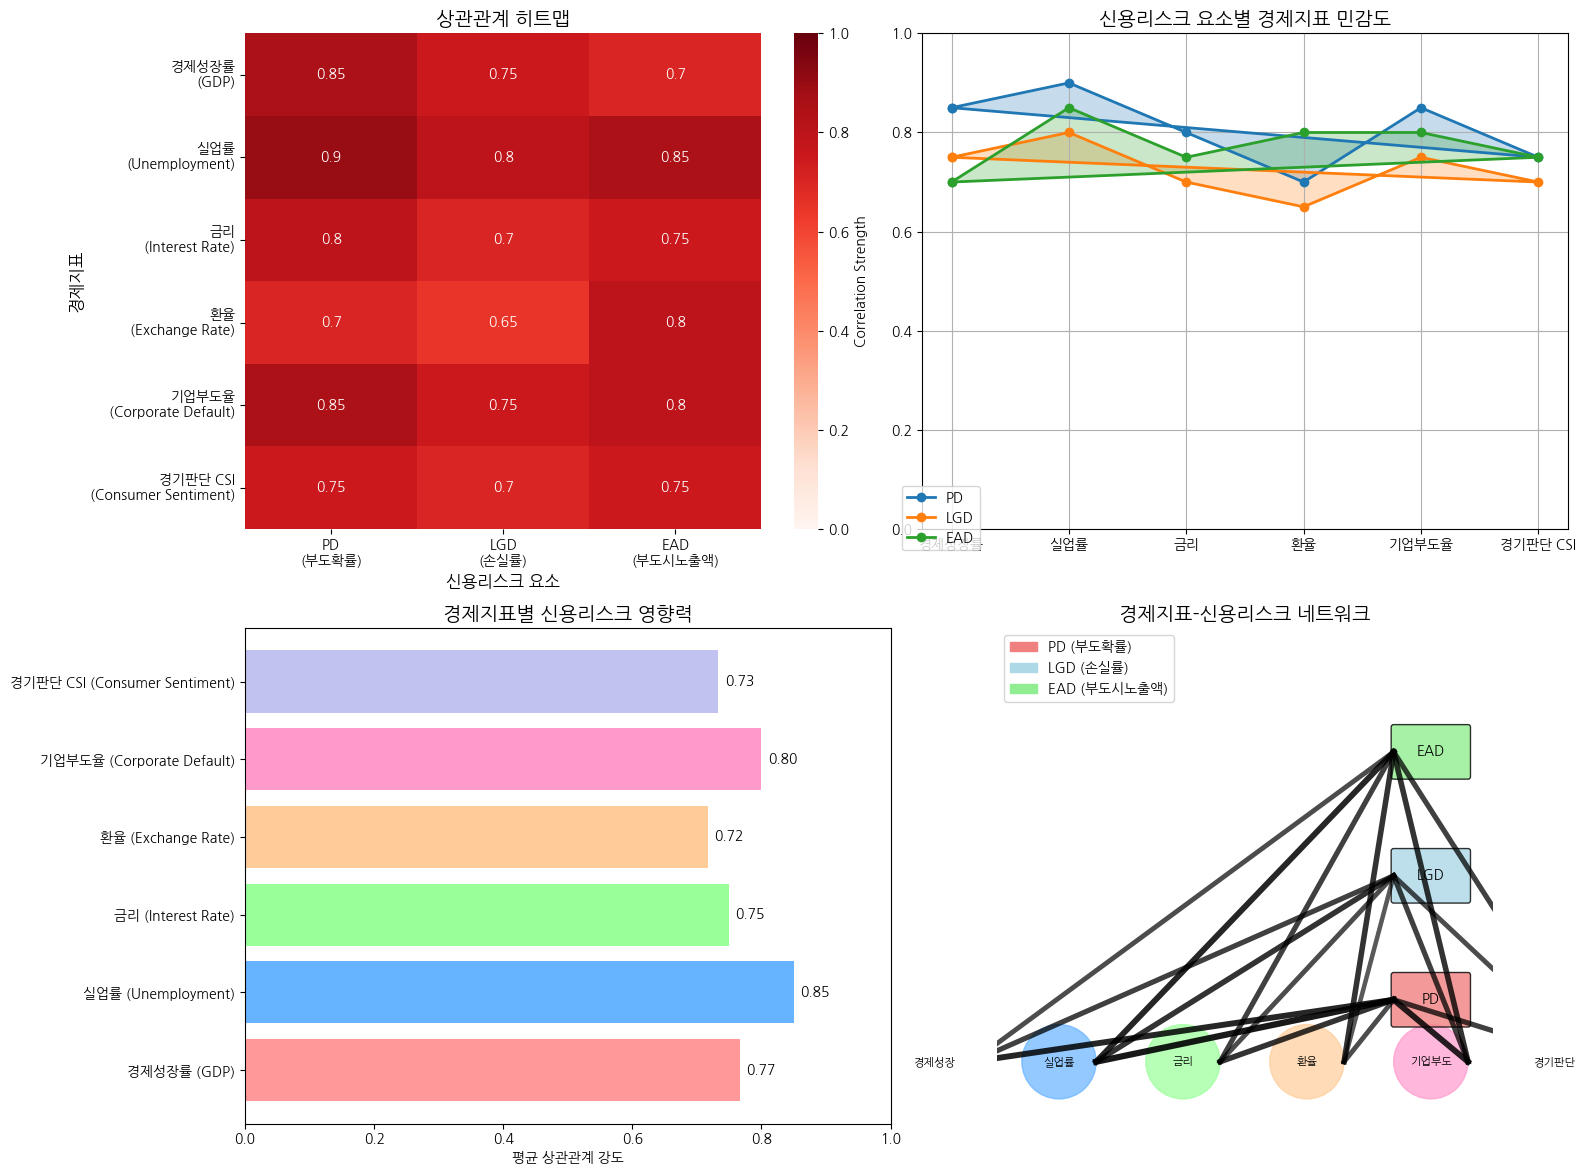

Economic Indicators vs Credit Risk Factors Correlation Summary

Í≤ΩÏ†úÏÑ±Ïû•Î•† (GDP):
  - PD (Î∂ÄÎèÑÌôïÎ•†): 0.85
  - LGD (ÏÜêÏã§Î•†): 0.75
  - EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°): 0.70

Ïã§ÏóÖÎ•† (Unemployment):
  - PD (Î∂ÄÎèÑÌôïÎ•†): 0.90
  - LGD (ÏÜêÏã§Î•†): 0.80
  - EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°): 0.85

Í∏àÎ¶¨ (Interest Rate):
  - PD (Î∂ÄÎèÑÌôïÎ•†): 0.80
  - LGD (ÏÜêÏã§Î•†): 0.70
  - EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°): 0.75

ÌôòÏú® (Exchange Rate):
  - PD (Î∂ÄÎèÑÌôïÎ•†): 0.70
  - LGD (ÏÜêÏã§Î•†): 0.65
  - EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°): 0.80

Í∏∞ÏóÖÎ∂ÄÎèÑÏú® (Corporate Default):
  - PD (Î∂ÄÎèÑÌôïÎ•†): 0.85
  - LGD (ÏÜêÏã§Î•†): 0.75
  - EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°): 0.80

Í≤ΩÍ∏∞ÌåêÎã® CSI (Consumer Sentiment):
  - PD (Î∂ÄÎèÑÌôïÎ•†): 0.75
  - LGD (ÏÜêÏã§Î•†): 0.70
  - EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°): 0.75

Overall Average Correlation: 0.769
Highest Correlation: 0.900
Lowest Correlation: 0.650

CORRELATION EXPLANATION (Korean):
GDP Growth: Í≤ΩÏ†úÏÑ±Ïû•Î•†
Unemployment: Ïã§ÏóÖÎ•†
Interest Rate: Í∏àÎ¶¨
Exchange Rate: ÌôòÏú®
Corp

In [ ]:
# @title ÏãúÍ∞ÅÌôî4
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï (ÏΩîÎû©ÏóêÏÑú Ïã§Ìñâ Ïãú ÌïÑÏöî)
#plt.rcParams['font.family'] = 'DejaVu Sans'
#plt.rcParams['axes.unicode_minus'] = False

#ÏúÑÏùò ÎëêÏ§Ñ ÌïúÍ∏Ä Ìè∞Ìä∏ ÏïàÎÇòÏò§Í≥† ÎÑ§Î™®Î°ú ÎÇòÏôÄÏÑú ÏïÑÎûòÏôÄ Í∞ôÏù¥ ÏàòÏ†ï
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.unicode_minus'] = False

# Îç∞Ïù¥ÌÑ∞ Ï†ïÏùò
indicators = ['Í≤ΩÏ†úÏÑ±Ïû•Î•†\n(GDP)', 'Ïã§ÏóÖÎ•†\n(Unemployment)', 'Í∏àÎ¶¨\n(Interest Rate)',
              'ÌôòÏú®\n(Exchange Rate)', 'Í∏∞ÏóÖÎ∂ÄÎèÑÏú®\n(Corporate Default)', 'Í≤ΩÍ∏∞ÌåêÎã® CSI\n(Consumer Sentiment)']
risk_factors = ['PD\n(Î∂ÄÎèÑÌôïÎ•†)', 'LGD\n(ÏÜêÏã§Î•†)', 'EAD\n(Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°)']

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∞ïÎèÑ Îß§Ìä∏Î¶≠Ïä§ (1: Í∞ïÌïú ÏñëÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ, 0: ÏÉÅÍ¥ÄÏóÜÏùå, -1: Í∞ïÌïú ÏùåÏùò ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ)
# Í≤ΩÏ†ú ÏïÖÌôî ÏãúÎÇòÎ¶¨Ïò§ Í∏∞Ï§ÄÏúºÎ°ú ÏÑ§Ï†ï
correlation_matrix = np.array([
    [0.85, 0.75, 0.70],  # Í≤ΩÏ†úÏÑ±Ïû•Î•† (GDP‚Üì Ïãú)
    [0.90, 0.80, 0.85],  # Ïã§ÏóÖÎ•† (Ïã§ÏóÖÎ•†‚Üë Ïãú)
    [0.80, 0.70, 0.75],  # Í∏àÎ¶¨ (Í∏àÎ¶¨‚Üë Ïãú)
    [0.70, 0.65, 0.80],  # ÌôòÏú® (ÌôòÏú®‚Üë Ïãú)
    [0.85, 0.75, 0.80],  # Í∏∞ÏóÖÎ∂ÄÎèÑÏú® (Í∏∞ÏóÖÎ∂ÄÎèÑÏú®‚Üë Ïãú)
    [0.75, 0.70, 0.75]   # Í≤ΩÍ∏∞ÌåêÎã® CSI (CSI‚Üì Ïãú)
])

# ÏãúÍ∞ÅÌôî ÏÉùÏÑ±
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("",fontsize=10, fontweight='bold', y=0.95)

# 1. ÌûàÌä∏Îßµ
sns.heatmap(correlation_matrix,
            xticklabels=risk_factors,
            yticklabels=indicators,
            annot=True,
            cmap='Reds',
            vmin=0, vmax=1,
            ax=ax1,
            cbar_kws={'label': 'Correlation Strength'})
ax1.set_title('ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ïã†Ïö©Î¶¨Ïä§ÌÅ¨ ÏöîÏÜå', fontsize=12)
ax1.set_ylabel('Í≤ΩÏ†úÏßÄÌëú', fontsize=12)

# 2. Î†àÏù¥Îçî Ï∞®Ìä∏
angles = np.linspace(0, 2*np.pi, len(indicators), endpoint=False).tolist()
angles += angles[:1]  # ÏõêÏùÑ ÏôÑÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥

for i, risk_factor in enumerate(['PD', 'LGD', 'EAD']):
    values = correlation_matrix[:, i].tolist()
    values += values[:1]  # ÏõêÏùÑ ÏôÑÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥

    ax2.plot(angles, values, 'o-', linewidth=2, label=risk_factor)
    ax2.fill(angles, values, alpha=0.25)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels([ind.split('\n')[0] for ind in indicators])
ax2.set_ylim(0, 1)
ax2.set_title('Ïã†Ïö©Î¶¨Ïä§ÌÅ¨ ÏöîÏÜåÎ≥Ñ Í≤ΩÏ†úÏßÄÌëú ÎØºÍ∞êÎèÑ', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax2.grid(True)

# 3. ÎßâÎåÄ Í∑∏ÎûòÌîÑ (ÏßÄÌëúÎ≥Ñ ÌèâÍ∑† ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ)
avg_correlation = np.mean(correlation_matrix, axis=1)
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc', '#c2c2f0']

bars = ax3.barh(range(len(indicators)), avg_correlation, color=colors)
ax3.set_yticks(range(len(indicators)))
ax3.set_yticklabels([ind.replace('\n', ' ') for ind in indicators])
ax3.set_xlabel('ÌèâÍ∑† ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∞ïÎèÑ')
ax3.set_title('Í≤ΩÏ†úÏßÄÌëúÎ≥Ñ Ïã†Ïö©Î¶¨Ïä§ÌÅ¨ ÏòÅÌñ•Î†•', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)

# ÎßâÎåÄ ÏúÑÏóê Í∞í ÌëúÏãú
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', ha='left', va='center', fontweight='bold')

# 4. ÎÑ§Ìä∏ÏõåÌÅ¨ Îã§Ïù¥Ïñ¥Í∑∏Îû® Ïä§ÌÉÄÏùº
ax4.set_xlim(-2, 2)
ax4.set_ylim(-2, 2)
ax4.set_aspect('equal')

# Í≤ΩÏ†úÏßÄÌëú ÎÖ∏Îìú (ÏôºÏ™Ω)
indicator_positions = [(i-2.5, -1.5) for i in range(len(indicators))]
risk_positions = [(1.5, i-1) for i in range(len(risk_factors))]

# ÎÖ∏Îìú Í∑∏Î¶¨Í∏∞
for i, (pos, indicator) in enumerate(zip(indicator_positions, indicators)):
    circle = plt.Circle((pos[0], pos[1]), 0.3, color=colors[i], alpha=0.7)
    ax4.add_patch(circle)
    ax4.text(pos[0], pos[1], indicator.split('\n')[0][:4], ha='center', va='center',
             fontsize=8, fontweight='bold')

for i, (pos, risk) in enumerate(zip(risk_positions, risk_factors)):
    rect = FancyBboxPatch((pos[0]-0.3, pos[1]-0.2), 0.6, 0.4,
                          boxstyle="round,pad=0.02",
                          facecolor=['lightcoral', 'lightblue', 'lightgreen'][i],
                          alpha=0.8)
    ax4.add_patch(rect)
    ax4.text(pos[0], pos[1], risk.split('\n')[0], ha='center', va='center',
             fontsize=10, fontweight='bold')

# Ïó∞Í≤∞ÏÑ† Í∑∏Î¶¨Í∏∞ (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í∞ïÎèÑÏóê Îî∞Îùº ÏÑ† ÍµµÍ∏∞ Ï°∞Ï†à)
for i, ind_pos in enumerate(indicator_positions):
    for j, risk_pos in enumerate(risk_positions):
        strength = correlation_matrix[i, j]
        ax4.plot([ind_pos[0]+0.3, risk_pos[0]-0.3], [ind_pos[1], risk_pos[1]],
                'k-', alpha=strength, linewidth=strength*5)

ax4.set_title('Í≤ΩÏ†úÏßÄÌëú-Ïã†Ïö©Î¶¨Ïä§ÌÅ¨ ÎÑ§Ìä∏ÏõåÌÅ¨', fontsize=14, fontweight='bold')
ax4.axis('off')

# Î≤îÎ°Ä Ï∂îÍ∞Ä
legend_elements = [
    mpatches.Patch(color='lightcoral', label='PD (Î∂ÄÎèÑÌôïÎ•†)'),
    mpatches.Patch(color='lightblue', label='LGD (ÏÜêÏã§Î•†)'),
    mpatches.Patch(color='lightgreen', label='EAD (Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï°)')
]
ax4.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÏöîÏïΩ ÌÖåÏù¥Î∏î Ï∂úÎ†•
print("=" * 80)
print("Economic Indicators vs Credit Risk Factors Correlation Summary")
print("=" * 80)
for i, indicator in enumerate(indicators):
    print(f"\n{indicator.replace(chr(10), ' ')}:")
    for j, risk_factor in enumerate(risk_factors):
        print(f"  - {risk_factor.replace(chr(10), ' ')}: {correlation_matrix[i,j]:.2f}")

print(f"\n{'='*80}")
print("Overall Average Correlation:", f"{np.mean(correlation_matrix):.3f}")
print("Highest Correlation:", f"{np.max(correlation_matrix):.3f}")
print("Lowest Correlation:", f"{np.min(correlation_matrix):.3f}")

# ÌïúÍ∏Ä ÏÑ§Î™Ö Ï∂îÍ∞Ä
print(f"\n{'='*80}")
print("CORRELATION EXPLANATION (Korean):")
print("GDP Growth: Í≤ΩÏ†úÏÑ±Ïû•Î•†")
print("Unemployment: Ïã§ÏóÖÎ•†")
print("Interest Rate: Í∏àÎ¶¨")
print("Exchange Rate: ÌôòÏú®")
print("Corp Default: Í∏∞ÏóÖÎ∂ÄÎèÑÏú®")
print("Consumer Sentiment: Í≤ΩÍ∏∞ÌåêÎã®CSI")
print("PD: Î∂ÄÎèÑÌôïÎ•† (Probability of Default)")
print("LGD: ÏÜêÏã§Î•† (Loss Given Default)")
print("EAD: Î∂ÄÎèÑÏãúÎÖ∏Ï∂úÏï° (Exposure at Default)")